In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.optimize import root_scalar
from adaptive_integrator import integrate
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

import warnings
warnings.filterwarnings('ignore', 'The iteration is not making good progress')


π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


 
def j_fdm(t, y, gamma):
    r, dydtau = y
    dydtau2 = (2 * gamma - gamma**2)/(4 * (r**3)) - (1/(r**2)) - r/(4 * (t**2))
    return [dydtau, dydtau2]


def j_cdm(t, y):
    r, dydtau = y
    dydtau2 =  - 1/(r**2) - r/(4 * (t**2))
    return [dydtau, dydtau2]


# Full analytic turnaround radius
def r_turnaround_full(tau, gamma): 
    def expression(y_ta):
        return y_ta**4 - 4 * y_ta * (tau**2) + (2 * gamma - gamma**2) * (tau**2)
    factor = 0.635 * (1 + 0.01 * np.log10(1 + gamma))
    #print(factor)
    r_ta_initial = factor * (8 * (tau**2))**(1/3)
    sol = optimize.fsolve(expression, r_ta_initial, xtol=1e-10)[0]
    return sol





# Event function for maximum (dy/dtau = 0)
def event_y_max(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_max.terminal = False  # Do not stop integration here
event_y_max.direction = -1    # Detect decreasing slope (peak reached)
# Event function for minimum (dy/dtau = 0 after y_max)
def event_y_min(t, y, *args):
    return y[1]  # Detect when velocity (dy/dtau) is zero
event_y_min.terminal = True   # Stop integration here
event_y_min.direction = 1     # Detect increasing slope (trough reached)




def y_fdm(gamma, y_i):
    v_i = y_i / (2 * tau_i)
    y0 = [y_i, v_i]
    tau_arr = np.geomspace(tau_i, tau_f, 10000)
    sol = solve_ivp(j_fdm, [tau_i, tau_f], y0, args=(gamma,), 
                    method='RK45', t_eval=tau_arr, 
                    rtol=1e-5, atol=1e-5, events=[event_y_max, event_y_min])
    if sol.t_events[0].size > 0:
        tau_ta = sol.t_events[0][0]
        y_ta = sol.y_events[0][0][0]
        return sol, (y_i, tau_ta, y_ta)  
    return sol, None  


def yta_true_min(gamma, initial_y_i):
    y_i = initial_y_i
    true_yi = y_i 
    initial_y_ta = float('inf') 
    initial_tau_ta = None
    min_found = False

    #print(f"\n**Finding the true minima of y_ta for gamma = {gamma:.2e}**")
    while not min_found:
        sol, turnaround_point = y_fdm(gamma, y_i)
        if not turnaround_point:
            break 
        y_i, tau_ta, y_ta = turnaround_point  
        #print(f" y_i = {y_i:.4e}, tau_ta = {tau_ta:.4e}, y_ta = {y_ta:.4e}")
        if y_ta < initial_y_ta:
            initial_y_ta = y_ta
            initial_tau_ta = tau_ta
            true_yi = y_i  
            y_i *= 0.9 
        else:
            min_found = True  
    stable_yi = true_yi  
    stable_yta_min = initial_y_ta   
    while True:
        yi_up = stable_yi * 1.01  
        yi_down = stable_yi * 0.99  
        sol_up, turnaround_up = y_fdm(gamma, yi_up)
        sol_down, turnaround_down = y_fdm(gamma, yi_down)
        
        if not turnaround_up or not turnaround_down:
            break  

        yi_up, tau_ta_up, y_ta_up = turnaround_up
        yi_down, tau_ta_down, y_ta_down = turnaround_down

        #print(f"Stabilizing: after increasing -> y_i = {yi_up:.4e}, y_ta = {y_ta_up:.4e}")
       # print(f"Stabilizing: after decreasing -> y_i = {yi_down:.4e}, y_ta = {y_ta_down:.4e}")

        if y_ta_up < stable_yta_min:
            stable_yta_min = y_ta_up
            initial_tau_ta = tau_ta_up
            stable_yi = yi_up
        elif y_ta_down < stable_yta_min:
            stable_yta_min = y_ta_down
            initial_tau_ta = tau_ta_down
            stable_yi = yi_down
        else:
            break  

    print(f"\n**Final true minima:** gamma = {gamma:.2e}, y_i = {stable_yi:.4e}, tau_ta = {initial_tau_ta:.4e}, y_ta = {stable_yta_min:.4e}\n")

    return gamma, stable_yi, initial_tau_ta, stable_yta_min


In [ ]:
# Now, we want to observe the changes in the true values of y_ta,min(gamma)
# and tau_ta,min(gamma) with the variations in the value of tau_i.  


**Final true minima:** gamma = 1.00e-10, y_i = 3.2930e-11, tau_ta = 1.2092e-15, y_ta = 1.0577e-10


**Final true minima:** gamma = 1.29e-09, y_i = 1.2240e-10, tau_ta = 3.5926e-13, y_ta = 5.9349e-09


**Final true minima:** gamma = 1.67e-08, y_i = 3.1450e-10, tau_ta = 7.2867e-11, y_ta = 2.1603e-07


**Final true minima:** gamma = 2.15e-07, y_i = 7.1614e-10, tau_ta = 9.1534e-09, y_ta = 5.5085e-06


**Final true minima:** gamma = 2.78e-06, y_i = 1.5489e-09, tau_ta = 8.7769e-07, y_ta = 1.1629e-04


**Final true minima:** gamma = 3.59e-05, y_i = 3.2482e-09, tau_ta = 7.1932e-05, y_ta = 2.2038e-03


**Final true minima:** gamma = 4.64e-04, y_i = 6.6825e-09, tau_ta = 5.3299e-03, y_ta = 3.8989e-02


**Final true minima:** gamma = 5.99e-03, y_i = 1.3464e-08, tau_ta = 3.6692e-01, y_ta = 6.5612e-01


**Final true minima:** gamma = 7.74e-02, y_i = 2.6845e-08, tau_ta = 2.2715e+01, y_ta = 1.0283e+01


**Final true minima:** gamma = 1.00e+00, y_i = 4.5042e-08, tau_ta = 4.9932e+02, y_ta = 8.0767e+01



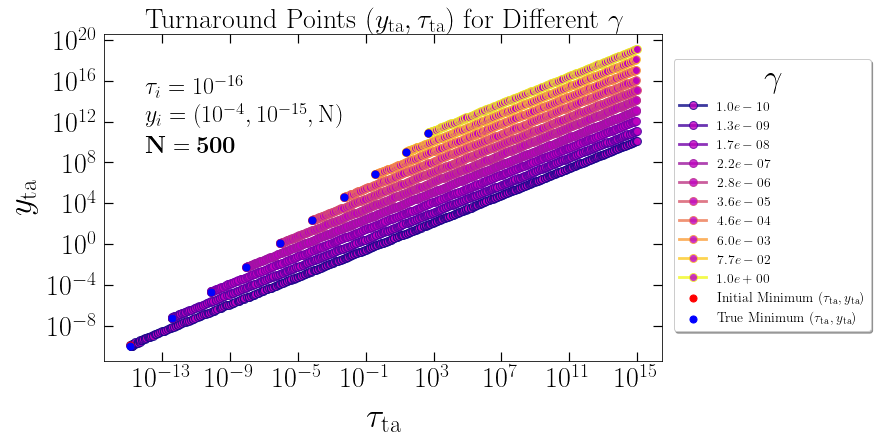

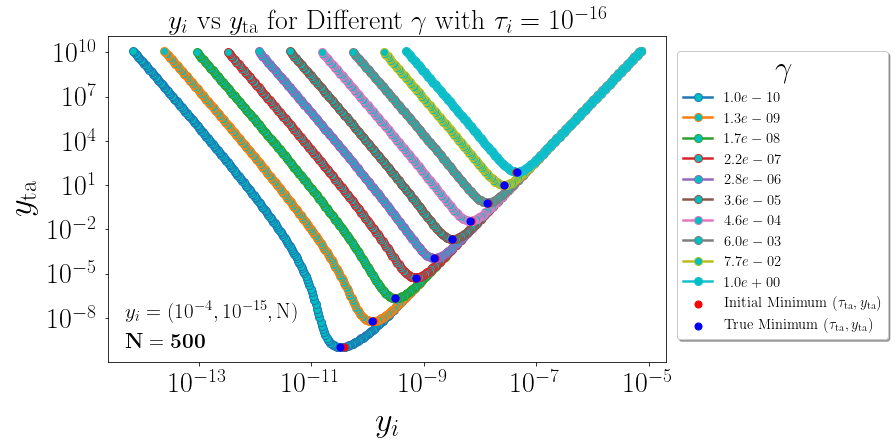

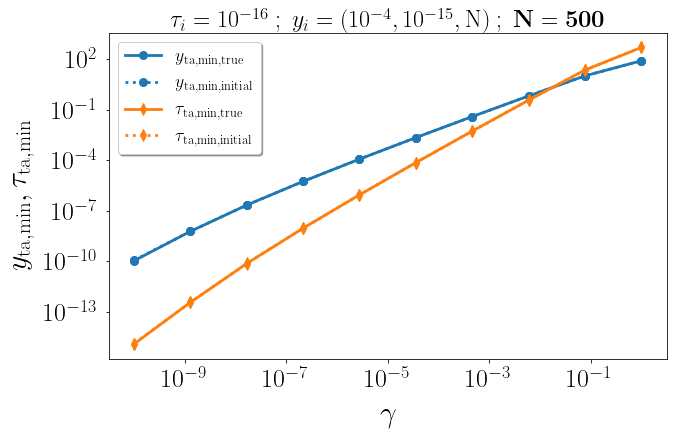


 **Initial minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 3.8474e-11, Tau_ta: 1.2604e-15, Y_ta: 1.1245e-10
Gamma: 1.3e-09, Y_i: 1.2365e-10, Tau_ta: 3.5974e-13, Y_ta: 5.9458e-09
Gamma: 1.7e-08, Y_i: 3.0830e-10, Tau_ta: 7.3123e-11, Y_ta: 2.1631e-07
Gamma: 2.2e-07, Y_i: 7.3068e-10, Tau_ta: 9.1649e-09, Y_ta: 5.5174e-06
Gamma: 2.8e-06, Y_i: 1.5645e-09, Tau_ta: 8.7794e-07, Y_ta: 1.1635e-04
Gamma: 3.6e-05, Y_i: 3.1842e-09, Tau_ta: 7.2142e-05, Y_ta: 2.2070e-03
Gamma: 4.6e-04, Y_i: 6.8182e-09, Tau_ta: 5.3432e-03, Y_ta: 3.9072e-02
Gamma: 6.0e-03, Y_i: 1.3877e-08, Tau_ta: 3.6805e-01, Y_ta: 6.5785e-01
Gamma: 7.7e-02, Y_i: 2.6845e-08, Tau_ta: 2.2715e+01, Y_ta: 1.0283e+01
Gamma: 1.0e+00, Y_i: 4.4596e-08, Tau_ta: 4.9994e+02, Y_ta: 8.0821e+01

**True minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 3.2930e-11, Tau_ta: 1.2092e-15, Y_ta: 1.0577e-10
Gamma: 1.3e-09, Y_i: 1.2240e-10, Tau_ta: 3.5926e-13, Y_ta: 5.9349e-09
Gamma: 1.7e-08, Y_i: 3.1450e-10, Tau_ta: 7.2867e-11, Y_ta: 2.1603e-07
Gamma: 2.2e-

In [2]:
# y_ta_min, tau_ta_min for various gamma-values with tau_i = 1e-16.


gamma_values = np.geomspace(1e-10, 1, 10)
N = 500
yi_values = np.geomspace(1e-4, 1e-15, N) 
tau_i, tau_f = 1e-16, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  



min_turnaround_pts = []
gamma_results = {}
for gamma in gamma_values:
    gamma_results[gamma] = {y_i: y_fdm(gamma, y_i) for y_i in yi_values}
    all_turnaround_pts = [turnaround for _, (_, turnaround) in gamma_results[gamma].items() if turnaround]
    if all_turnaround_pts:
        min_yi_ta, min_tau_ta, min_y_ta = min(all_turnaround_pts, key=lambda x: x[1])
        min_turnaround_pts.append((gamma, min_yi_ta, min_tau_ta, min_y_ta))

true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]

gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))




#plotting y vs tau for different values of gamma, each with different values of y_i
#for gamma in gamma_values:
   # fig1, ax1 = plt.subplots(figsize=(10, 6))
    #plt.rc('lines', linewidth = 2.8)
   # plt.rcParams['font.family'] = 'serif'
    #plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    #plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
    #for y_i in yi_values:
      #  sol, turnaround = gamma_results[gamma][y_i] 
       # tau_vals, y_vals = sol.t, sol.y[0]
       # ax1.loglog(tau_vals, y_vals, alpha=0.8, label=f"${y_i:.1e}$")
    #ax1.tick_params(axis='x', pad=6.9)
    #ax1.tick_params(axis='y', pad=6.9)
    #plt.xticks(fontsize=24)
    #plt.yticks(fontsize=24)
    #plt.xlabel(r'$\tau$', fontsize=30)
    #plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    #ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    #plt.savefig(f"yvstau3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    #plt.show()


    
    
    
    
fig2, ax2 = plt.subplots(figsize=(10, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
        sorted_points = sorted(set(zip(tau_ta, y_ta)))
        tau_ta, y_ta = zip(*sorted_points) 
        y_ta_scaled = [y * 10**i for y in y_ta]  
        ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], marker='o', 
                   label=f"${gamma:.1e}$", markersize=8, markerfacecolor='m', alpha=0.8)

gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)
min_yta_arr_scaled = [y * 10**i for i, y in enumerate(min_yta_arr)]
true_min_yta_arr_scaled = [y * 10**i for i, y in enumerate(true_min_yta_arr)]
ax2.scatter(min_tauta_arr, min_yta_arr_scaled, color='r', s = 50, zorder=10, label="Initial Minimum $( \\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax2.scatter(true_min_tauta_arr, true_min_yta_arr_scaled, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")



plt.text(1e-14, 5e14, r'$\tau_i = 10^{-16}$', fontsize=24)
plt.text(1e-14, 1e12, r'$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=24)
plt.text(1e-14, 1e9, r'$\mathbf{N = 500}$', fontsize=24)



ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=28)
ax2.legend(prop={'size':13.7}, loc=(1.02, 0.09), shadow=True, title=r'$\gamma$', title_fontsize=33,
           facecolor='white', fontsize=12)
#plt.savefig("yta_vs_tauta3_N500.pdf", bbox_inches='tight')
plt.show()




#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=8, markerfacecolor='c', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")


    
ax3.scatter(min_yi_arr, min_yta_arr, color='r', s = 50, zorder=10, label="Initial Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax3.scatter(true_min_yi_arr, true_min_yta_arr, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta}, y_\\mathrm{ta})$")

plt.text(5e-15, 1e-8, '$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=21)
plt.text(5e-15, 1e-10, r'$\mathbf{N = 500}$', fontsize=21)

ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax3.set_xlabel(r'$y_i$', fontsize=34.5, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax3.set_title(r'$y_i$ vs $y_\mathrm{ta}$ for Different $\gamma$ with $\tau_i = 10^{-16}$', fontsize=28)
ax3.legend(prop={'size':14.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=31,
           facecolor='white', fontsize=12)
#plt.savefig("yi_vs_yta3_N500.pdf", bbox_inches='tight')
plt.show()




# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
#true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]
gamma_arr, min_yi_arr1, min_tauta_arr1, min_yta_arr1 = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr1, true_min_tauta_arr1, true_min_yta_arr1 = zip(*true_min_turnaround_pts)

ax4.loglog(gamma_arr, true_min_yta_arr1, marker='o', markersize=8, color='C0', ls='-', label="True $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_yta_arr1, marker='o',  markersize=8,color='C0', ls=':', label="Initial $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, true_min_tauta_arr1, marker='d',  markersize=8, color='C1', ls='-', label="True $\tau_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_tauta_arr1, marker='d',  markersize=8, color='C1', ls=':', label="Initial $\tau_{\mathrm{ta, min}}$")

ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min, true}$", r"$y_\mathrm{ta, min, initial}$", r"$\tau_\mathrm{ta, min, true}$"
           , r"$\tau_\mathrm{ta, min, initial}$"], prop={'size':18}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)
plt.title(r' $\tau_i = 10^{-16}\;;\; y_i = (10^{-4}, 10^{-15}, \mathrm{N}) \;;\;  \mathbf{N = 500}$', fontsize=24)
#plt.savefig("ytamin_vs_gamma3_N500.pdf", bbox_inches='tight')
plt.show()


print("\n **Initial minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")

print("\n**True minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in true_min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")




**Final true minima:** gamma = 1.00e-10, y_i = 6.7812e-12, tau_ta = 1.0997e-14, y_ta = 5.8746e-10


**Final true minima:** gamma = 1.29e-09, y_i = 1.7250e-11, tau_ta = 1.9750e-12, y_ta = 1.9580e-08


**Final true minima:** gamma = 1.67e-08, y_i = 3.8859e-11, tau_ta = 2.3188e-10, y_ta = 4.7605e-07


**Final true minima:** gamma = 2.15e-07, y_i = 8.3206e-11, tau_ta = 2.1409e-08, y_ta = 9.7903e-06


**Final true minima:** gamma = 2.78e-06, y_i = 1.7463e-10, tau_ta = 1.7135e-06, y_ta = 1.8258e-04


**Final true minima:** gamma = 3.59e-05, y_i = 3.5542e-10, tau_ta = 1.2504e-04, y_ta = 3.1962e-03


**Final true minima:** gamma = 4.64e-04, y_i = 7.2337e-10, tau_ta = 8.5408e-03, y_ta = 5.3512e-02


**Final true minima:** gamma = 5.99e-03, y_i = 1.4575e-09, tau_ta = 5.5363e-01, y_ta = 8.6479e-01


**Final true minima:** gamma = 7.74e-02, y_i = 2.8769e-09, tau_ta = 3.2751e+01, y_ta = 1.3143e+01


**Final true minima:** gamma = 1.00e+00, y_i = 4.7792e-09, tau_ta = 7.0010e+02, y_ta = 1.0130e+02



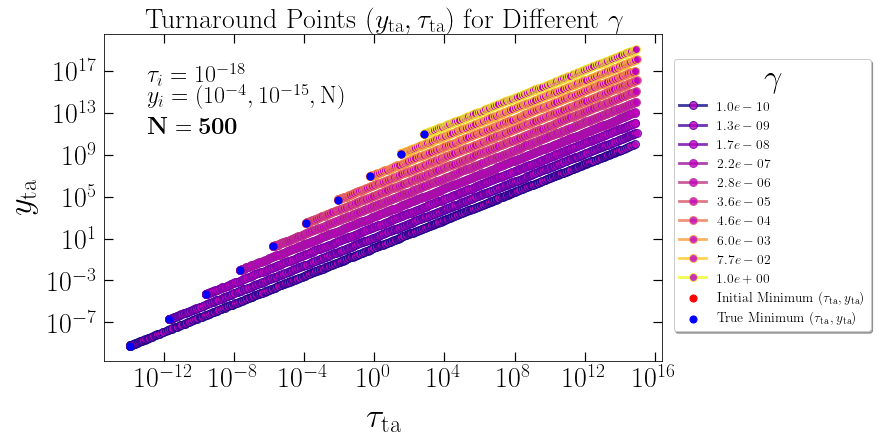

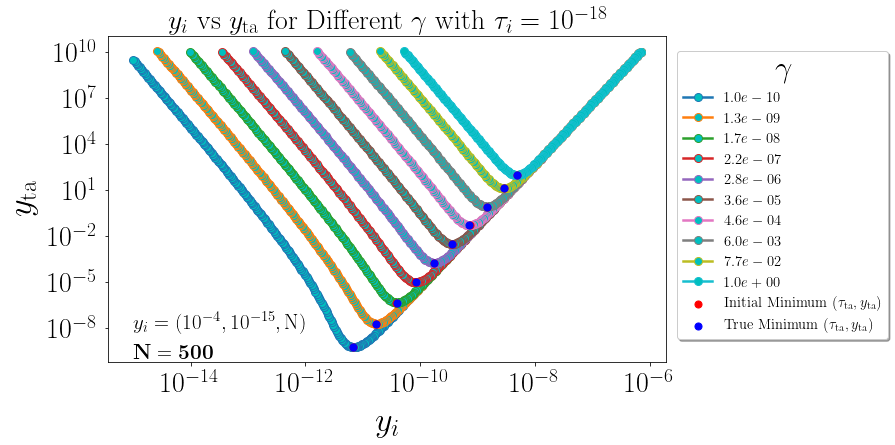

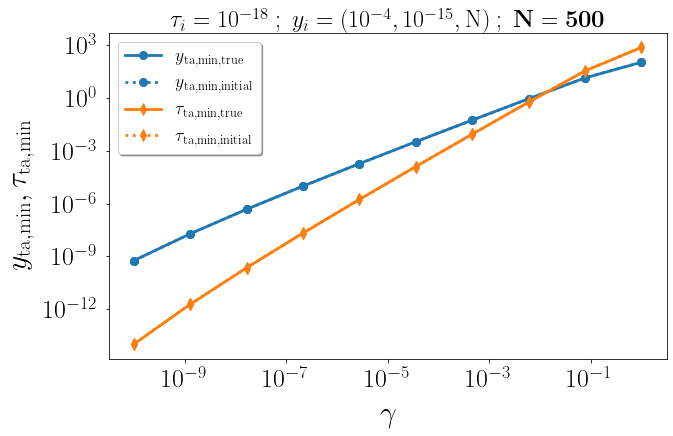


 **Initial minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 6.8497e-12, Tau_ta: 1.0984e-14, Y_ta: 5.8771e-10
Gamma: 1.3e-09, Y_i: 1.7079e-11, Tau_ta: 1.9784e-12, Y_ta: 1.9594e-08
Gamma: 1.7e-08, Y_i: 3.8474e-11, Tau_ta: 2.3222e-10, Y_ta: 4.7635e-07
Gamma: 2.2e-07, Y_i: 8.2382e-11, Tau_ta: 2.1441e-08, Y_ta: 9.7972e-06
Gamma: 2.8e-06, Y_i: 1.7640e-10, Tau_ta: 1.7147e-06, Y_ta: 1.8271e-04
Gamma: 3.6e-05, Y_i: 3.5901e-10, Tau_ta: 1.2501e-04, Y_ta: 3.1964e-03
Gamma: 4.6e-04, Y_i: 7.3068e-10, Tau_ta: 8.5440e-03, Y_ta: 5.3536e-02
Gamma: 6.0e-03, Y_i: 1.4871e-09, Tau_ta: 5.5529e-01, Y_ta: 8.6682e-01
Gamma: 7.7e-02, Y_i: 2.8769e-09, Tau_ta: 3.2751e+01, Y_ta: 1.3143e+01
Gamma: 1.0e+00, Y_i: 4.7792e-09, Tau_ta: 7.0010e+02, Y_ta: 1.0130e+02

**True minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 6.7812e-12, Tau_ta: 1.0997e-14, Y_ta: 5.8746e-10
Gamma: 1.3e-09, Y_i: 1.7250e-11, Tau_ta: 1.9750e-12, Y_ta: 1.9580e-08
Gamma: 1.7e-08, Y_i: 3.8859e-11, Tau_ta: 2.3188e-10, Y_ta: 4.7605e-07
Gamma: 2.2e-

In [3]:
# y_ta_min, tau_ta_min for various gamma-values with tau_i = 1e-18.


gamma_values = np.geomspace(1e-10, 1, 10)
N = 500
yi_values = np.geomspace(1e-4, 1e-15, N) 
tau_i, tau_f = 1e-18, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  



min_turnaround_pts = []
gamma_results = {}
for gamma in gamma_values:
    gamma_results[gamma] = {y_i: y_fdm(gamma, y_i) for y_i in yi_values}
    all_turnaround_pts = [turnaround for _, (_, turnaround) in gamma_results[gamma].items() if turnaround]
    if all_turnaround_pts:
        min_yi_ta, min_tau_ta, min_y_ta = min(all_turnaround_pts, key=lambda x: x[1])
        min_turnaround_pts.append((gamma, min_yi_ta, min_tau_ta, min_y_ta))

true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]

gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))




#plotting y vs tau for different values of gamma, each with different values of y_i
#for gamma in gamma_values:
   # fig1, ax1 = plt.subplots(figsize=(10, 6))
    #plt.rc('lines', linewidth = 2.8)
   # plt.rcParams['font.family'] = 'serif'
    #plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    #plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
    #for y_i in yi_values:
      #  sol, turnaround = gamma_results[gamma][y_i] 
       # tau_vals, y_vals = sol.t, sol.y[0]
       # ax1.loglog(tau_vals, y_vals, alpha=0.8, label=f"${y_i:.1e}$")
    #ax1.tick_params(axis='x', pad=6.9)
    #ax1.tick_params(axis='y', pad=6.9)
    #plt.xticks(fontsize=24)
    #plt.yticks(fontsize=24)
    #plt.xlabel(r'$\tau$', fontsize=30)
    #plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    #ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    #plt.savefig(f"yvstau3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    #plt.show()


    
    
    
    
fig2, ax2 = plt.subplots(figsize=(10, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
        sorted_points = sorted(set(zip(tau_ta, y_ta)))
        tau_ta, y_ta = zip(*sorted_points) 
        y_ta_scaled = [y * 10**i for y in y_ta]  
        ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], marker='o', 
                   label=f"${gamma:.1e}$", markersize=8, markerfacecolor='m', alpha=0.8)

gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)
min_yta_arr_scaled = [y * 10**i for i, y in enumerate(min_yta_arr)]
true_min_yta_arr_scaled = [y * 10**i for i, y in enumerate(true_min_yta_arr)]
ax2.scatter(min_tauta_arr, min_yta_arr_scaled, color='r', s = 50, zorder=10, label="Initial Minimum $( \\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax2.scatter(true_min_tauta_arr, true_min_yta_arr_scaled, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")



plt.text(1e-13, 1e16, r'$\tau_i = 10^{-18}$', fontsize=24)
plt.text(1e-13, 1e14, r'$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=24)
plt.text(1e-13, 1e11, r'$\mathbf{N = 500}$', fontsize=24)



ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=28)
ax2.legend(prop={'size':13.7}, loc=(1.02, 0.09), shadow=True, title=r'$\gamma$', title_fontsize=33,
           facecolor='white', fontsize=12)
#plt.savefig("yta_vs_tauta3_N500.pdf", bbox_inches='tight')
plt.show()




#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=8, markerfacecolor='c', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")


    
ax3.scatter(min_yi_arr, min_yta_arr, color='r', s = 50, zorder=10, label="Initial Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax3.scatter(true_min_yi_arr, true_min_yta_arr, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta}, y_\\mathrm{ta})$")

plt.text(1e-15, 1e-8, '$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=21)
plt.text(1e-15, 1e-10, r'$\mathbf{N = 500}$', fontsize=21)

ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax3.set_xlabel(r'$y_i$', fontsize=34.5, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax3.set_title(r'$y_i$ vs $y_\mathrm{ta}$ for Different $\gamma$ with $\tau_i = 10^{-18}$', fontsize=28)
ax3.legend(prop={'size':14.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=31,
           facecolor='white', fontsize=12)
#plt.savefig("yi_vs_yta3_N500.pdf", bbox_inches='tight')
plt.show()




# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
#true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]
gamma_arr, min_yi_arr2, min_tauta_arr2, min_yta_arr2 = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr2, true_min_tauta_arr2, true_min_yta_arr2 = zip(*true_min_turnaround_pts)

ax4.loglog(gamma_arr, true_min_yta_arr2, marker='o', markersize=8, color='C0', ls='-', label="True $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_yta_arr2, marker='o',  markersize=8,color='C0', ls=':', label="Initial $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, true_min_tauta_arr2, marker='d',  markersize=8, color='C1', ls='-', label="True $\tau_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_tauta_arr2, marker='d',  markersize=8, color='C1', ls=':', label="Initial $\tau_{\mathrm{ta, min}}$")

ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min, true}$", r"$y_\mathrm{ta, min, initial}$", r"$\tau_\mathrm{ta, min, true}$"
           , r"$\tau_\mathrm{ta, min, initial}$"], prop={'size':18}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)
plt.title(r' $\tau_i = 10^{-18}\;;\; y_i = (10^{-4}, 10^{-15}, \mathrm{N}) \;;\;  \mathbf{N = 500}$', fontsize=24)
#plt.savefig("ytamin_vs_gamma3_N500.pdf", bbox_inches='tight')
plt.show()


print("\n **Initial minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")

print("\n**True minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in true_min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")




**Final true minima:** gamma = 1.00e-10, y_i = 9.4613e-13, tau_ta = 5.2451e-14, y_ta = 1.7533e-09


**Final true minima:** gamma = 1.29e-09, y_i = 2.1100e-12, tau_ta = 5.8185e-12, y_ta = 4.0875e-08


**Final true minima:** gamma = 1.67e-08, y_i = 4.4729e-12, tau_ta = 5.1929e-10, y_ta = 8.2110e-07


**Final true minima:** gamma = 2.15e-07, y_i = 9.3812e-12, tau_ta = 4.0667e-08, y_ta = 1.5088e-05


**Final true minima:** gamma = 2.78e-06, y_i = 1.9093e-11, tau_ta = 2.9233e-06, y_ta = 2.6146e-04


**Final true minima:** gamma = 3.59e-05, y_i = 3.8474e-11, tau_ta = 1.9769e-04, y_ta = 4.3472e-03


**Final true minima:** gamma = 4.64e-04, y_i = 7.7522e-11, tau_ta = 1.2760e-02, y_ta = 7.0049e-02


**Final true minima:** gamma = 5.99e-03, y_i = 1.5453e-10, tau_ta = 7.9161e-01, y_ta = 1.0989e+00


**Final true minima:** gamma = 7.74e-02, y_i = 3.0217e-10, tau_ta = 4.5242e+01, y_ta = 1.6318e+01


**Final true minima:** gamma = 1.00e+00, y_i = 5.0198e-10, tau_ta = 9.4603e+02, y_ta = 1.2392e+02



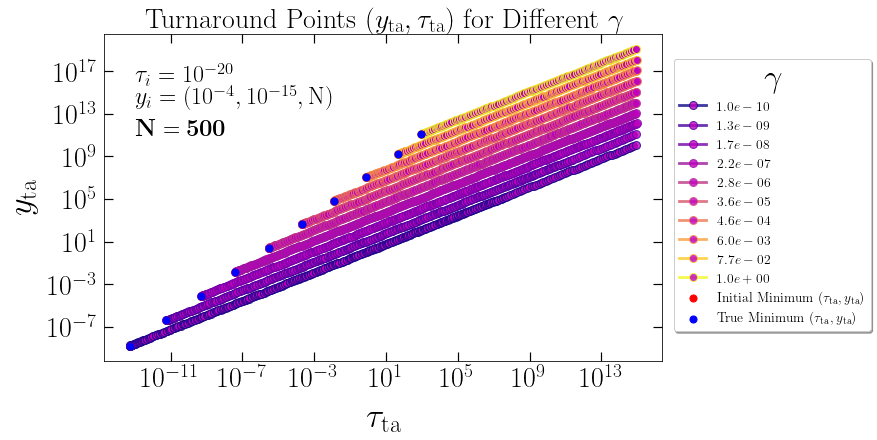

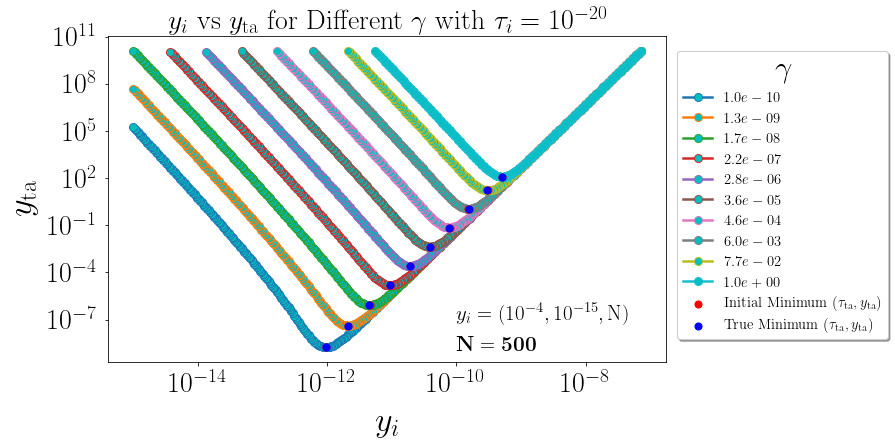

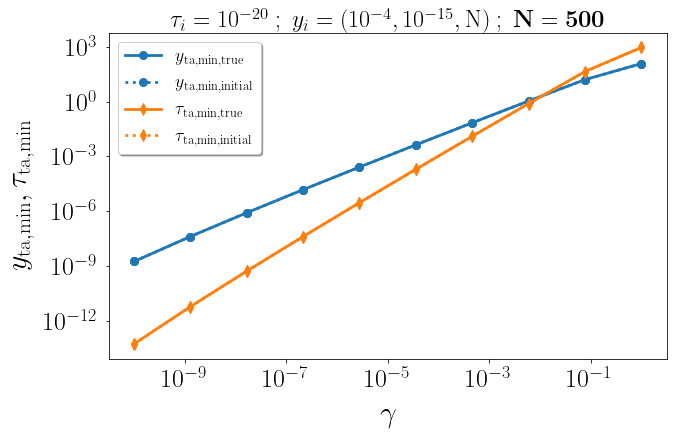


 **Initial minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 9.4613e-13, Tau_ta: 5.2451e-14, Y_ta: 1.7533e-09
Gamma: 1.3e-09, Y_i: 2.1314e-12, Tau_ta: 5.8190e-12, Y_ta: 4.0891e-08
Gamma: 1.7e-08, Y_i: 4.5637e-12, Tau_ta: 5.1954e-10, Y_ta: 8.2184e-07
Gamma: 2.2e-07, Y_i: 9.2883e-12, Tau_ta: 4.0684e-08, Y_ta: 1.5089e-05
Gamma: 2.8e-06, Y_i: 1.8904e-11, Tau_ta: 2.9262e-06, Y_ta: 2.6158e-04
Gamma: 3.6e-05, Y_i: 3.8474e-11, Tau_ta: 1.9769e-04, Y_ta: 4.3472e-03
Gamma: 4.6e-04, Y_i: 7.8305e-11, Tau_ta: 1.2766e-02, Y_ta: 7.0081e-02
Gamma: 6.0e-03, Y_i: 1.5148e-10, Tau_ta: 7.9381e-01, Y_ta: 1.1007e+00
Gamma: 7.7e-02, Y_i: 3.0830e-10, Tau_ta: 4.5291e+01, Y_ta: 1.6334e+01
Gamma: 1.0e+00, Y_i: 5.1218e-10, Tau_ta: 9.4710e+02, Y_ta: 1.2405e+02

**True minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 9.4613e-13, Tau_ta: 5.2451e-14, Y_ta: 1.7533e-09
Gamma: 1.3e-09, Y_i: 2.1100e-12, Tau_ta: 5.8185e-12, Y_ta: 4.0875e-08
Gamma: 1.7e-08, Y_i: 4.4729e-12, Tau_ta: 5.1929e-10, Y_ta: 8.2110e-07
Gamma: 2.2e-

In [9]:
# y_ta_min, tau_ta_min for various gamma-values with tau_i = 1e-20.


gamma_values = np.geomspace(1e-10, 1, 10)
N = 500
yi_values = np.geomspace(1e-4, 1e-15, N) 
tau_i, tau_f = 1e-20, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  



min_turnaround_pts = []
gamma_results = {}
for gamma in gamma_values:
    gamma_results[gamma] = {y_i: y_fdm(gamma, y_i) for y_i in yi_values}
    all_turnaround_pts = [turnaround for _, (_, turnaround) in gamma_results[gamma].items() if turnaround]
    if all_turnaround_pts:
        min_yi_ta, min_tau_ta, min_y_ta = min(all_turnaround_pts, key=lambda x: x[1])
        min_turnaround_pts.append((gamma, min_yi_ta, min_tau_ta, min_y_ta))

true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]

gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))




#plotting y vs tau for different values of gamma, each with different values of y_i
#for gamma in gamma_values:
   # fig1, ax1 = plt.subplots(figsize=(10, 6))
    #plt.rc('lines', linewidth = 2.8)
   # plt.rcParams['font.family'] = 'serif'
    #plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    #plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
    #for y_i in yi_values:
      #  sol, turnaround = gamma_results[gamma][y_i] 
       # tau_vals, y_vals = sol.t, sol.y[0]
       # ax1.loglog(tau_vals, y_vals, alpha=0.8, label=f"${y_i:.1e}$")
    #ax1.tick_params(axis='x', pad=6.9)
    #ax1.tick_params(axis='y', pad=6.9)
    #plt.xticks(fontsize=24)
    #plt.yticks(fontsize=24)
    #plt.xlabel(r'$\tau$', fontsize=30)
    #plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    #ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    #plt.savefig(f"yvstau3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    #plt.show()


    
    
    
    
fig2, ax2 = plt.subplots(figsize=(10, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
        sorted_points = sorted(set(zip(tau_ta, y_ta)))
        tau_ta, y_ta = zip(*sorted_points) 
        y_ta_scaled = [y * 10**i for y in y_ta]  
        ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], marker='o', 
                   label=f"${gamma:.1e}$", markersize=8, markerfacecolor='m', alpha=0.8)

gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)
min_yta_arr_scaled = [y * 10**i for i, y in enumerate(min_yta_arr)]
true_min_yta_arr_scaled = [y * 10**i for i, y in enumerate(true_min_yta_arr)]
ax2.scatter(min_tauta_arr, min_yta_arr_scaled, color='r', s = 50, zorder=10, label="Initial Minimum $( \\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax2.scatter(true_min_tauta_arr, true_min_yta_arr_scaled, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")



plt.text(1e-13, 1e16, r'$\tau_i = 10^{-20}$', fontsize=24)
plt.text(1e-13, 1e14, r'$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=24)
plt.text(1e-13, 1e11, r'$\mathbf{N = 500}$', fontsize=24)



ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=28)
ax2.legend(prop={'size':13.7}, loc=(1.02, 0.09), shadow=True, title=r'$\gamma$', title_fontsize=33,
           facecolor='white', fontsize=12)
#plt.savefig("yta_vs_tauta3_N500.pdf", bbox_inches='tight')
plt.show()




#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=8, markerfacecolor='c', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")


    
ax3.scatter(min_yi_arr, min_yta_arr, color='r', s = 50, zorder=10, label="Initial Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax3.scatter(true_min_yi_arr, true_min_yta_arr, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta}, y_\\mathrm{ta})$")

plt.text(1e-10, 1e-7, '$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=21)
plt.text(1e-10, 1e-9, r'$\mathbf{N = 500}$', fontsize=21)

ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax3.set_xlabel(r'$y_i$', fontsize=34.5, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax3.set_title(r'$y_i$ vs $y_\mathrm{ta}$ for Different $\gamma$ with $\tau_i = 10^{-20}$', fontsize=28)
ax3.legend(prop={'size':14.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=31,
           facecolor='white', fontsize=12)
#plt.savefig("yi_vs_yta3_N500.pdf", bbox_inches='tight')
plt.show()




# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
#true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]
gamma_arr, min_yi_arr3, min_tauta_arr3, min_yta_arr3 = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr3, true_min_tauta_arr3, true_min_yta_arr3 = zip(*true_min_turnaround_pts)

ax4.loglog(gamma_arr, true_min_yta_arr3, marker='o', markersize=8, color='C0', ls='-', label="True $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_yta_arr3, marker='o',  markersize=8,color='C0', ls=':', label="Initial $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, true_min_tauta_arr3, marker='d',  markersize=8, color='C1', ls='-', label="True $\tau_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_tauta_arr3, marker='d',  markersize=8, color='C1', ls=':', label="Initial $\tau_{\mathrm{ta, min}}$")

ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min, true}$", r"$y_\mathrm{ta, min, initial}$", r"$\tau_\mathrm{ta, min, true}$"
           , r"$\tau_\mathrm{ta, min, initial}$"], prop={'size':18}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)
plt.title(r' $\tau_i = 10^{-20}\;;\; y_i = (10^{-4}, 10^{-15}, \mathrm{N}) \;;\;  \mathbf{N = 500}$', fontsize=24)
#plt.savefig("ytamin_vs_gamma3_N500.pdf", bbox_inches='tight')
plt.show()


print("\n **Initial minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")

print("\n**True minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in true_min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")




**Final true minima:** gamma = 1.00e-10, y_i = 1.1448e-13, tau_ta = 1.4482e-13, y_ta = 3.4896e-09


**Final true minima:** gamma = 1.29e-09, y_i = 2.4271e-13, tau_ta = 1.2524e-11, y_ta = 6.8618e-08


**Final true minima:** gamma = 1.67e-08, y_i = 4.9926e-13, tau_ta = 9.6208e-10, y_ta = 1.2439e-06


**Final true minima:** gamma = 2.15e-07, y_i = 1.0264e-12, tau_ta = 6.8195e-08, y_ta = 2.1357e-05


**Final true minima:** gamma = 2.78e-06, y_i = 2.0666e-12, tau_ta = 4.5639e-06, y_ta = 3.5261e-04


**Final true minima:** gamma = 3.59e-05, y_i = 4.1232e-12, tau_ta = 2.9247e-04, y_ta = 5.6534e-03


**Final true minima:** gamma = 4.64e-04, y_i = 8.2247e-12, tau_ta = 1.8105e-02, y_ta = 8.8560e-02


**Final true minima:** gamma = 5.99e-03, y_i = 1.6234e-11, tau_ta = 1.0863e+00, y_ta = 1.3583e+00


**Final true minima:** gamma = 7.74e-02, y_i = 3.2036e-11, tau_ta = 6.0386e+01, y_ta = 1.9800e+01


**Final true minima:** gamma = 1.00e+00, y_i = 5.2693e-11, tau_ta = 1.2406e+03, y_ta = 1.4858e+02



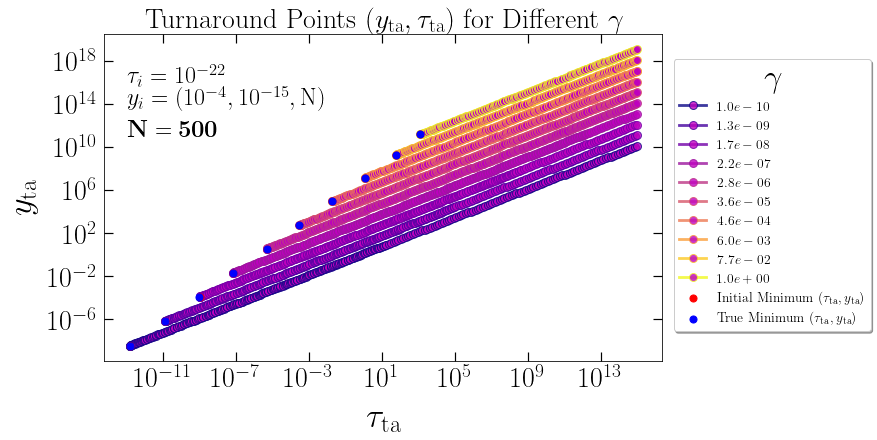

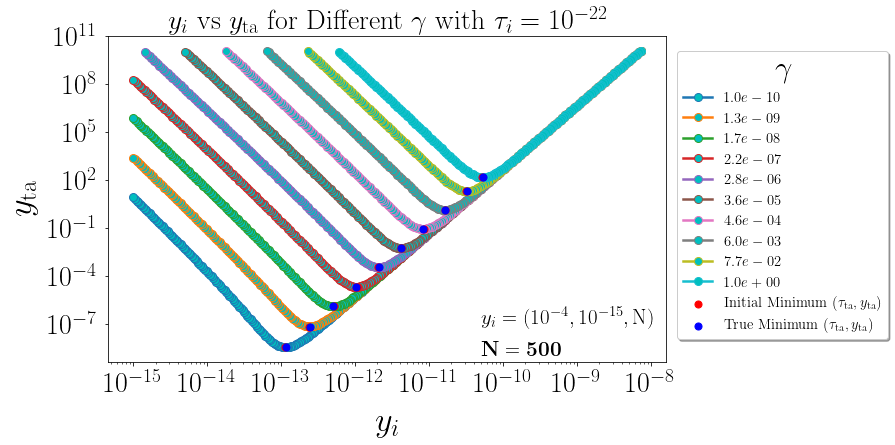

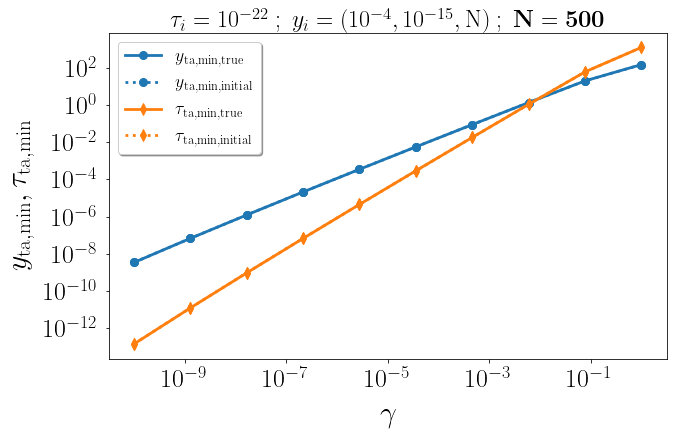


 **Initial minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 1.1223e-13, Tau_ta: 1.4516e-13, Y_ta: 3.4946e-09
Gamma: 1.3e-09, Y_i: 2.4030e-13, Tau_ta: 1.2532e-11, Y_ta: 6.8627e-08
Gamma: 1.7e-08, Y_i: 5.1454e-13, Tau_ta: 9.6566e-10, Y_ta: 1.2479e-06
Gamma: 2.2e-07, Y_i: 1.0472e-12, Tau_ta: 6.8418e-08, Y_ta: 2.1413e-05
Gamma: 2.8e-06, Y_i: 2.0259e-12, Tau_ta: 4.5755e-06, Y_ta: 3.5307e-04
Gamma: 3.6e-05, Y_i: 4.1232e-12, Tau_ta: 2.9247e-04, Y_ta: 5.6534e-03
Gamma: 4.6e-04, Y_i: 8.3917e-12, Tau_ta: 1.8141e-02, Y_ta: 8.8704e-02
Gamma: 6.0e-03, Y_i: 1.6234e-11, Tau_ta: 1.0863e+00, Y_ta: 1.3583e+00
Gamma: 7.7e-02, Y_i: 3.1405e-11, Tau_ta: 6.0487e+01, Y_ta: 1.9817e+01
Gamma: 1.0e+00, Y_i: 5.2172e-11, Tau_ta: 1.2419e+03, Y_ta: 1.4866e+02

**True minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 1.1448e-13, Tau_ta: 1.4482e-13, Y_ta: 3.4896e-09
Gamma: 1.3e-09, Y_i: 2.4271e-13, Tau_ta: 1.2524e-11, Y_ta: 6.8618e-08
Gamma: 1.7e-08, Y_i: 4.9926e-13, Tau_ta: 9.6208e-10, Y_ta: 1.2439e-06
Gamma: 2.2e-

In [11]:
# y_ta_min, tau_ta_min for various gamma-values with tau_i = 1e-22.


gamma_values = np.geomspace(1e-10, 1, 10)
N = 500
yi_values = np.geomspace(1e-4, 1e-15, N) 
tau_i, tau_f = 1e-22, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  



min_turnaround_pts = []
gamma_results = {}
for gamma in gamma_values:
    gamma_results[gamma] = {y_i: y_fdm(gamma, y_i) for y_i in yi_values}
    all_turnaround_pts = [turnaround for _, (_, turnaround) in gamma_results[gamma].items() if turnaround]
    if all_turnaround_pts:
        min_yi_ta, min_tau_ta, min_y_ta = min(all_turnaround_pts, key=lambda x: x[1])
        min_turnaround_pts.append((gamma, min_yi_ta, min_tau_ta, min_y_ta))

true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]

gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))




#plotting y vs tau for different values of gamma, each with different values of y_i
#for gamma in gamma_values:
   # fig1, ax1 = plt.subplots(figsize=(10, 6))
    #plt.rc('lines', linewidth = 2.8)
   # plt.rcParams['font.family'] = 'serif'
    #plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    #plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
    #for y_i in yi_values:
      #  sol, turnaround = gamma_results[gamma][y_i] 
       # tau_vals, y_vals = sol.t, sol.y[0]
       # ax1.loglog(tau_vals, y_vals, alpha=0.8, label=f"${y_i:.1e}$")
    #ax1.tick_params(axis='x', pad=6.9)
    #ax1.tick_params(axis='y', pad=6.9)
    #plt.xticks(fontsize=24)
    #plt.yticks(fontsize=24)
    #plt.xlabel(r'$\tau$', fontsize=30)
    #plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    #ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    #plt.savefig(f"yvstau3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    #plt.show()


    
    
    
    
fig2, ax2 = plt.subplots(figsize=(10, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
        sorted_points = sorted(set(zip(tau_ta, y_ta)))
        tau_ta, y_ta = zip(*sorted_points) 
        y_ta_scaled = [y * 10**i for y in y_ta]  
        ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], marker='o', 
                   label=f"${gamma:.1e}$", markersize=8, markerfacecolor='m', alpha=0.8)

gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)
min_yta_arr_scaled = [y * 10**i for i, y in enumerate(min_yta_arr)]
true_min_yta_arr_scaled = [y * 10**i for i, y in enumerate(true_min_yta_arr)]
ax2.scatter(min_tauta_arr, min_yta_arr_scaled, color='r', s = 50, zorder=10, label="Initial Minimum $( \\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax2.scatter(true_min_tauta_arr, true_min_yta_arr_scaled, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")



plt.text(1e-13, 1e16, r'$\tau_i = 10^{-22}$', fontsize=24)
plt.text(1e-13, 1e14, r'$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=24)
plt.text(1e-13, 1e11, r'$\mathbf{N = 500}$', fontsize=24)



ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=28)
ax2.legend(prop={'size':13.7}, loc=(1.02, 0.09), shadow=True, title=r'$\gamma$', title_fontsize=33,
           facecolor='white', fontsize=12)
#plt.savefig("yta_vs_tauta3_N500.pdf", bbox_inches='tight')
plt.show()




#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=8, markerfacecolor='c', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")


    
ax3.scatter(min_yi_arr, min_yta_arr, color='r', s = 50, zorder=10, label="Initial Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax3.scatter(true_min_yi_arr, true_min_yta_arr, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta}, y_\\mathrm{ta})$")

plt.text(5e-11, 1e-7, '$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=21)
plt.text(5e-11, 1e-9, r'$\mathbf{N = 500}$', fontsize=21)


ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax3.set_xlabel(r'$y_i$', fontsize=34.5, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax3.set_title(r'$y_i$ vs $y_\mathrm{ta}$ for Different $\gamma$ with $\tau_i = 10^{-22}$', fontsize=28)
ax3.legend(prop={'size':14.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=31,
           facecolor='white', fontsize=12)
#plt.savefig("yi_vs_yta3_N500.pdf", bbox_inches='tight')
plt.show()




# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
#true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]
gamma_arr, min_yi_arr4, min_tauta_arr4, min_yta_arr4 = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr4, true_min_tauta_arr4, true_min_yta_arr4 = zip(*true_min_turnaround_pts)

ax4.loglog(gamma_arr, true_min_yta_arr4, marker='o', markersize=8, color='C0', ls='-', label="True $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_yta_arr4, marker='o',  markersize=8,color='C0', ls=':', label="Initial $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, true_min_tauta_arr4, marker='d',  markersize=8, color='C1', ls='-', label="True $\tau_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_tauta_arr4, marker='d',  markersize=8, color='C1', ls=':', label="Initial $\tau_{\mathrm{ta, min}}$")

ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min, true}$", r"$y_\mathrm{ta, min, initial}$", r"$\tau_\mathrm{ta, min, true}$"
           , r"$\tau_\mathrm{ta, min, initial}$"], prop={'size':18}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)
plt.title(r' $\tau_i = 10^{-22}\;;\; y_i = (10^{-4}, 10^{-15}, \mathrm{N}) \;;\;  \mathbf{N = 500}$', fontsize=24)
#plt.savefig("ytamin_vs_gamma3_N500.pdf", bbox_inches='tight')
plt.show()


print("\n **Initial minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")

print("\n**True minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in true_min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")




**Final true minima:** gamma = 1.00e-10, y_i = 1.3047e-14, tau_ta = 3.0080e-13, y_ta = 5.7164e-09


**Final true minima:** gamma = 1.29e-09, y_i = 2.6823e-14, tau_ta = 2.2681e-11, y_ta = 1.0233e-07


**Final true minima:** gamma = 1.67e-08, y_i = 5.4591e-14, tau_ta = 1.5872e-09, y_ta = 1.7415e-06


**Final true minima:** gamma = 2.15e-07, y_i = 1.0999e-13, tau_ta = 1.0521e-07, y_ta = 2.8568e-05


**Final true minima:** gamma = 2.78e-06, y_i = 2.1928e-13, tau_ta = 6.6929e-06, y_ta = 4.5577e-04


**Final true minima:** gamma = 3.59e-05, y_i = 4.3745e-13, tau_ta = 4.1195e-04, y_ta = 7.1121e-03


**Final true minima:** gamma = 4.64e-04, y_i = 8.7198e-13, tau_ta = 2.4691e-02, y_ta = 1.0902e-01


**Final true minima:** gamma = 5.99e-03, y_i = 1.7051e-12, tau_ta = 1.4423e+00, y_ta = 1.6422e+00


**Final true minima:** gamma = 7.74e-02, y_i = 3.3319e-12, tau_ta = 7.8421e+01, y_ta = 2.3583e+01


**Final true minima:** gamma = 1.00e+00, y_i = 5.5352e-12, tau_ta = 1.5879e+03, y_ta = 1.7527e+02



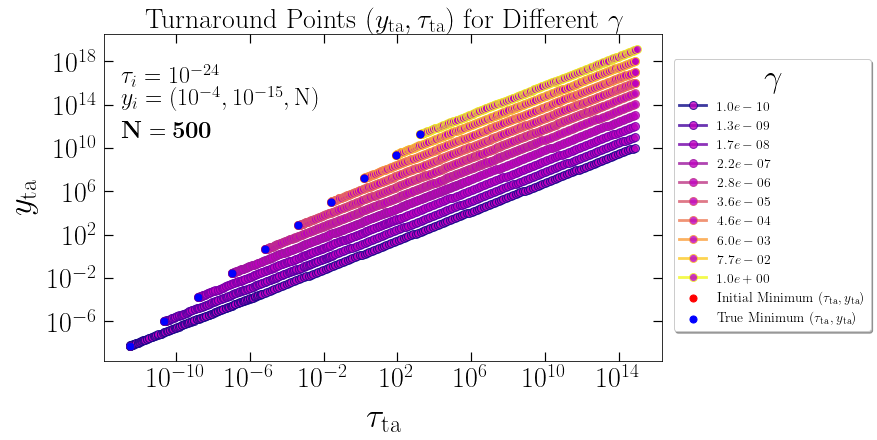

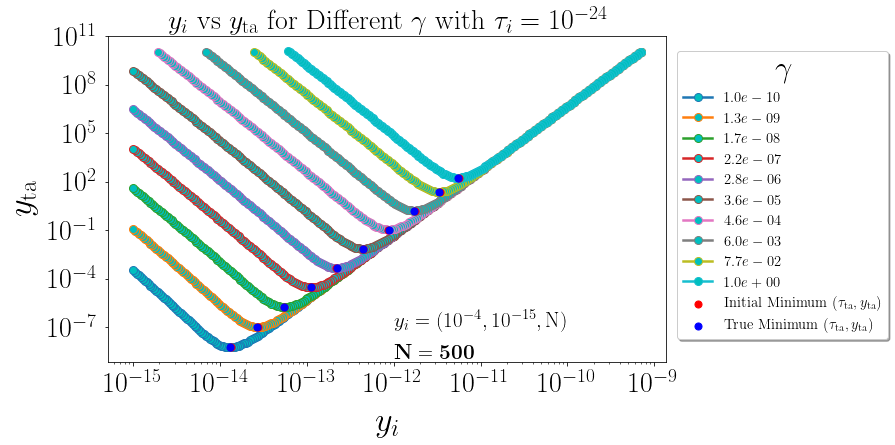

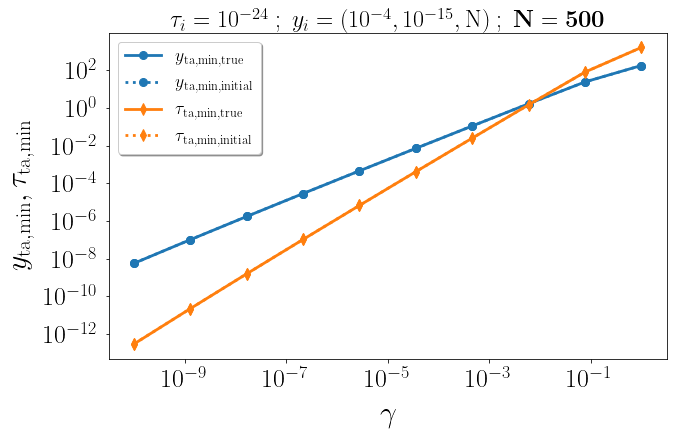


 **Initial minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 1.3312e-14, Tau_ta: 3.0162e-13, Y_ta: 5.7297e-09
Gamma: 1.3e-09, Y_i: 2.7094e-14, Tau_ta: 2.2688e-11, Y_ta: 1.0237e-07
Gamma: 1.7e-08, Y_i: 5.5142e-14, Tau_ta: 1.5878e-09, Y_ta: 1.7422e-06
Gamma: 2.2e-07, Y_i: 1.1223e-13, Tau_ta: 1.0541e-07, Y_ta: 2.8615e-05
Gamma: 2.8e-06, Y_i: 2.1711e-13, Tau_ta: 6.7023e-06, Y_ta: 4.5612e-04
Gamma: 3.6e-05, Y_i: 4.4187e-13, Tau_ta: 4.1204e-04, Y_ta: 7.1142e-03
Gamma: 4.6e-04, Y_i: 8.5480e-13, Tau_ta: 2.4733e-02, Y_ta: 1.0912e-01
Gamma: 6.0e-03, Y_i: 1.7397e-12, Tau_ta: 1.4441e+00, Y_ta: 1.6440e+00
Gamma: 7.7e-02, Y_i: 3.3655e-12, Tau_ta: 7.8450e+01, Y_ta: 2.3592e+01
Gamma: 1.0e+00, Y_i: 5.5911e-12, Tau_ta: 1.5896e+03, Y_ta: 1.7541e+02

**True minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 1.3047e-14, Tau_ta: 3.0080e-13, Y_ta: 5.7164e-09
Gamma: 1.3e-09, Y_i: 2.6823e-14, Tau_ta: 2.2681e-11, Y_ta: 1.0233e-07
Gamma: 1.7e-08, Y_i: 5.4591e-14, Tau_ta: 1.5872e-09, Y_ta: 1.7415e-06
Gamma: 2.2e-

In [12]:
# y_ta_min, tau_ta_min for various gamma-values with tau_i = 1e-24.


gamma_values = np.geomspace(1e-10, 1, 10)
N = 500
yi_values = np.geomspace(1e-4, 1e-15, N) 
tau_i, tau_f = 1e-24, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  



min_turnaround_pts = []
gamma_results = {}
for gamma in gamma_values:
    gamma_results[gamma] = {y_i: y_fdm(gamma, y_i) for y_i in yi_values}
    all_turnaround_pts = [turnaround for _, (_, turnaround) in gamma_results[gamma].items() if turnaround]
    if all_turnaround_pts:
        min_yi_ta, min_tau_ta, min_y_ta = min(all_turnaround_pts, key=lambda x: x[1])
        min_turnaround_pts.append((gamma, min_yi_ta, min_tau_ta, min_y_ta))

true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]

gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))




#plotting y vs tau for different values of gamma, each with different values of y_i
#for gamma in gamma_values:
   # fig1, ax1 = plt.subplots(figsize=(10, 6))
    #plt.rc('lines', linewidth = 2.8)
   # plt.rcParams['font.family'] = 'serif'
    #plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    #plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
    #for y_i in yi_values:
      #  sol, turnaround = gamma_results[gamma][y_i] 
       # tau_vals, y_vals = sol.t, sol.y[0]
       # ax1.loglog(tau_vals, y_vals, alpha=0.8, label=f"${y_i:.1e}$")
    #ax1.tick_params(axis='x', pad=6.9)
    #ax1.tick_params(axis='y', pad=6.9)
    #plt.xticks(fontsize=24)
    #plt.yticks(fontsize=24)
    #plt.xlabel(r'$\tau$', fontsize=30)
    #plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    #ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    #plt.savefig(f"yvstau3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    #plt.show()


    
    
    
    
fig2, ax2 = plt.subplots(figsize=(10, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
        sorted_points = sorted(set(zip(tau_ta, y_ta)))
        tau_ta, y_ta = zip(*sorted_points) 
        y_ta_scaled = [y * 10**i for y in y_ta]  
        ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], marker='o', 
                   label=f"${gamma:.1e}$", markersize=8, markerfacecolor='m', alpha=0.8)

gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)
min_yta_arr_scaled = [y * 10**i for i, y in enumerate(min_yta_arr)]
true_min_yta_arr_scaled = [y * 10**i for i, y in enumerate(true_min_yta_arr)]
ax2.scatter(min_tauta_arr, min_yta_arr_scaled, color='r', s = 50, zorder=10, label="Initial Minimum $( \\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax2.scatter(true_min_tauta_arr, true_min_yta_arr_scaled, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")



plt.text(1e-13, 1e16, r'$\tau_i = 10^{-24}$', fontsize=24)
plt.text(1e-13, 1e14, r'$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=24)
plt.text(1e-13, 1e11, r'$\mathbf{N = 500}$', fontsize=24)



ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=28)
ax2.legend(prop={'size':13.7}, loc=(1.02, 0.09), shadow=True, title=r'$\gamma$', title_fontsize=33,
           facecolor='white', fontsize=12)
#plt.savefig("yta_vs_tauta3_N500.pdf", bbox_inches='tight')
plt.show()




#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=8, markerfacecolor='c', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")


    
ax3.scatter(min_yi_arr, min_yta_arr, color='r', s = 50, zorder=10, label="Initial Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax3.scatter(true_min_yi_arr, true_min_yta_arr, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta}, y_\\mathrm{ta})$")

plt.text(1e-12, 1e-7, '$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=21)
plt.text(1e-12, 1e-9, r'$\mathbf{N = 500}$', fontsize=21)

ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax3.set_xlabel(r'$y_i$', fontsize=34.5, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax3.set_title(r'$y_i$ vs $y_\mathrm{ta}$ for Different $\gamma$ with $\tau_i = 10^{-24}$', fontsize=28)
ax3.legend(prop={'size':14.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=31,
           facecolor='white', fontsize=12)
#plt.savefig("yi_vs_yta3_N500.pdf", bbox_inches='tight')
plt.show()




# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
#true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]
gamma_arr, min_yi_arr5, min_tauta_arr5, min_yta_arr5 = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr5, true_min_tauta_arr5, true_min_yta_arr5 = zip(*true_min_turnaround_pts)

ax4.loglog(gamma_arr, true_min_yta_arr5, marker='o', markersize=8, color='C0', ls='-', label="True $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_yta_arr5, marker='o',  markersize=8,color='C0', ls=':', label="Initial $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, true_min_tauta_arr5, marker='d',  markersize=8, color='C1', ls='-', label="True $\tau_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_tauta_arr5, marker='d',  markersize=8, color='C1', ls=':', label="Initial $\tau_{\mathrm{ta, min}}$")

ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min, true}$", r"$y_\mathrm{ta, min, initial}$", r"$\tau_\mathrm{ta, min, true}$"
           , r"$\tau_\mathrm{ta, min, initial}$"], prop={'size':18}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)
plt.title(r' $\tau_i = 10^{-24}\;;\; y_i = (10^{-4}, 10^{-15}, \mathrm{N}) \;;\;  \mathbf{N = 500}$', fontsize=24)
#plt.savefig("ytamin_vs_gamma3_N500.pdf", bbox_inches='tight')
plt.show()


print("\n **Initial minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")

print("\n**True minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in true_min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")




**Final true minima:** gamma = 1.00e-10, y_i = 1.4409e-15, tau_ta = 5.3334e-13, y_ta = 8.4022e-09


**Final true minima:** gamma = 1.29e-09, y_i = 2.9035e-15, tau_ta = 3.6874e-11, y_ta = 1.4182e-07


**Final true minima:** gamma = 1.67e-08, y_i = 5.8503e-15, tau_ta = 2.4216e-09, y_ta = 2.3121e-06


**Final true minima:** gamma = 2.15e-07, y_i = 1.1788e-14, tau_ta = 1.5291e-07, y_ta = 3.6709e-05


**Final true minima:** gamma = 2.78e-06, y_i = 2.3267e-14, tau_ta = 9.3603e-06, y_ta = 5.7064e-04


**Final true minima:** gamma = 3.59e-05, y_i = 4.5947e-14, tau_ta = 5.5866e-04, y_ta = 8.7215e-03


**Final true minima:** gamma = 4.64e-04, y_i = 9.0690e-14, tau_ta = 3.2631e-02, y_ta = 1.3138e-01


**Final true minima:** gamma = 5.99e-03, y_i = 1.7899e-13, tau_ta = 1.8646e+00, y_ta = 1.9502e+00


**Final true minima:** gamma = 7.74e-02, y_i = 3.4625e-13, tau_ta = 9.9569e+01, y_ta = 2.7667e+01


**Final true minima:** gamma = 1.00e+00, y_i = 5.7522e-13, tau_ta = 1.9914e+03, y_ta = 2.0393e+02



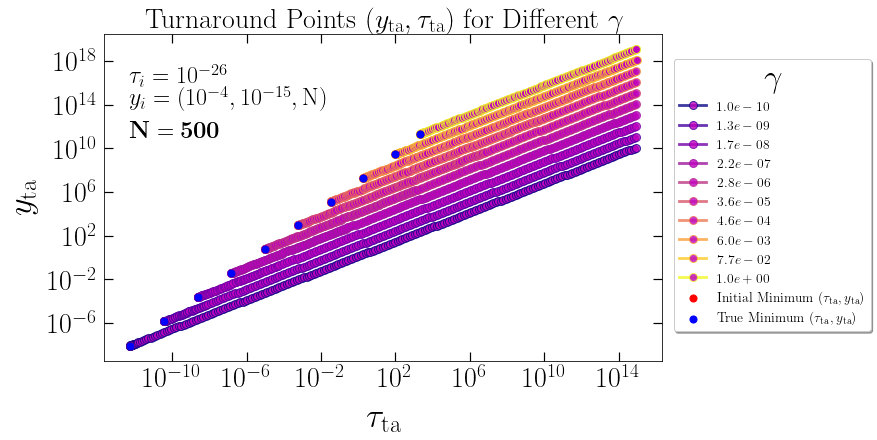

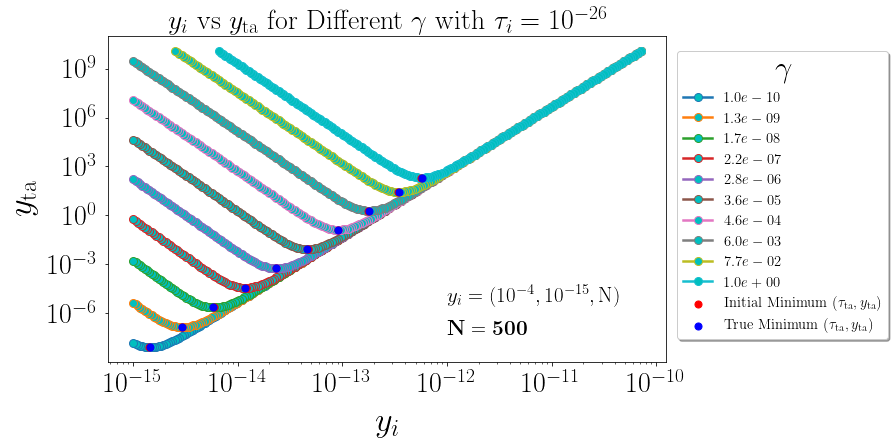

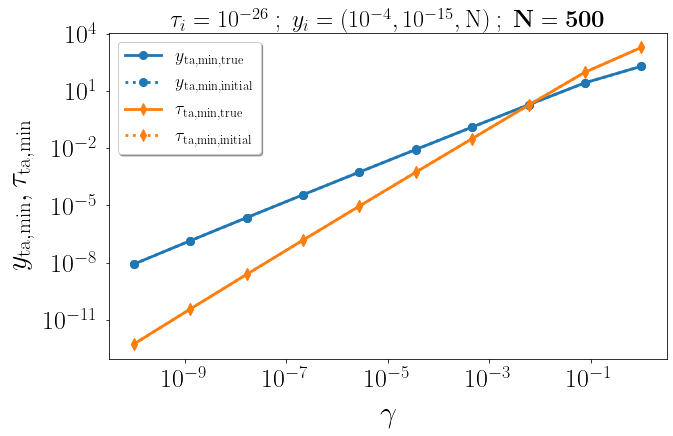


 **Initial minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 1.4266e-15, Tau_ta: 5.3364e-13, Y_ta: 8.4037e-09
Gamma: 1.3e-09, Y_i: 2.9035e-15, Tau_ta: 3.6874e-11, Y_ta: 1.4182e-07
Gamma: 1.7e-08, Y_i: 5.9094e-15, Tau_ta: 2.4215e-09, Y_ta: 2.3124e-06
Gamma: 2.2e-07, Y_i: 1.2027e-14, Tau_ta: 1.5341e-07, Y_ta: 3.6801e-05
Gamma: 2.8e-06, Y_i: 2.3267e-14, Tau_ta: 9.3603e-06, Y_ta: 5.7064e-04
Gamma: 3.6e-05, Y_i: 4.7353e-14, Tau_ta: 5.6054e-04, Y_ta: 8.7445e-03
Gamma: 4.6e-04, Y_i: 9.1606e-14, Tau_ta: 3.2630e-02, Y_ta: 1.3139e-01
Gamma: 6.0e-03, Y_i: 1.7721e-13, Tau_ta: 1.8659e+00, Y_ta: 1.9509e+00
Gamma: 7.7e-02, Y_i: 3.4282e-13, Tau_ta: 9.9688e+01, Y_ta: 2.7686e+01
Gamma: 1.0e+00, Y_i: 5.6952e-13, Tau_ta: 1.9918e+03, Y_ta: 2.0394e+02

**True minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 1.4409e-15, Tau_ta: 5.3334e-13, Y_ta: 8.4022e-09
Gamma: 1.3e-09, Y_i: 2.9035e-15, Tau_ta: 3.6874e-11, Y_ta: 1.4182e-07
Gamma: 1.7e-08, Y_i: 5.8503e-15, Tau_ta: 2.4216e-09, Y_ta: 2.3121e-06
Gamma: 2.2e-

In [17]:
# y_ta_min, tau_ta_min for various gamma-values with tau_i = 1e-26.


gamma_values = np.geomspace(1e-10, 1, 10)
N = 500
yi_values = np.geomspace(1e-4, 1e-15, N) 
tau_i, tau_f = 1e-26, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  



min_turnaround_pts = []
gamma_results = {}
for gamma in gamma_values:
    gamma_results[gamma] = {y_i: y_fdm(gamma, y_i) for y_i in yi_values}
    all_turnaround_pts = [turnaround for _, (_, turnaround) in gamma_results[gamma].items() if turnaround]
    if all_turnaround_pts:
        min_yi_ta, min_tau_ta, min_y_ta = min(all_turnaround_pts, key=lambda x: x[1])
        min_turnaround_pts.append((gamma, min_yi_ta, min_tau_ta, min_y_ta))

true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]

gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))




#plotting y vs tau for different values of gamma, each with different values of y_i
#for gamma in gamma_values:
   # fig1, ax1 = plt.subplots(figsize=(10, 6))
    #plt.rc('lines', linewidth = 2.8)
   # plt.rcParams['font.family'] = 'serif'
    #plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    #plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
    #for y_i in yi_values:
      #  sol, turnaround = gamma_results[gamma][y_i] 
       # tau_vals, y_vals = sol.t, sol.y[0]
       # ax1.loglog(tau_vals, y_vals, alpha=0.8, label=f"${y_i:.1e}$")
    #ax1.tick_params(axis='x', pad=6.9)
    #ax1.tick_params(axis='y', pad=6.9)
    #plt.xticks(fontsize=24)
    #plt.yticks(fontsize=24)
    #plt.xlabel(r'$\tau$', fontsize=30)
    #plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    #ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    #plt.savefig(f"yvstau3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    #plt.show()


    
    
    
    
fig2, ax2 = plt.subplots(figsize=(10, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
        sorted_points = sorted(set(zip(tau_ta, y_ta)))
        tau_ta, y_ta = zip(*sorted_points) 
        y_ta_scaled = [y * 10**i for y in y_ta]  
        ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], marker='o', 
                   label=f"${gamma:.1e}$", markersize=8, markerfacecolor='m', alpha=0.8)

gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)
min_yta_arr_scaled = [y * 10**i for i, y in enumerate(min_yta_arr)]
true_min_yta_arr_scaled = [y * 10**i for i, y in enumerate(true_min_yta_arr)]
ax2.scatter(min_tauta_arr, min_yta_arr_scaled, color='r', s = 50, zorder=10, label="Initial Minimum $( \\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax2.scatter(true_min_tauta_arr, true_min_yta_arr_scaled, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")



plt.text(5e-13, 1e16, r'$\tau_i = 10^{-26}$', fontsize=24)
plt.text(5e-13, 1e14, r'$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=24)
plt.text(5e-13, 1e11, r'$\mathbf{N = 500}$', fontsize=24)



ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=28)
ax2.legend(prop={'size':13.7}, loc=(1.02, 0.09), shadow=True, title=r'$\gamma$', title_fontsize=33,
           facecolor='white', fontsize=12)
#plt.savefig("yta_vs_tauta3_N500.pdf", bbox_inches='tight')
plt.show()




#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=8, markerfacecolor='c', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")


    
ax3.scatter(min_yi_arr, min_yta_arr, color='r', s = 50, zorder=10, label="Initial Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax3.scatter(true_min_yi_arr, true_min_yta_arr, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta}, y_\\mathrm{ta})$")

plt.text(1e-12, 5e-6, '$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=21)
plt.text(1e-12, 5e-8, r'$\mathbf{N = 500}$', fontsize=21)

ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax3.set_xlabel(r'$y_i$', fontsize=34.5, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax3.set_title(r'$y_i$ vs $y_\mathrm{ta}$ for Different $\gamma$ with $\tau_i = 10^{-26}$', fontsize=28)
ax3.legend(prop={'size':14.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=31,
           facecolor='white', fontsize=12)
#plt.savefig("yi_vs_yta3_N500.pdf", bbox_inches='tight')
plt.show()




# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
#true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]
gamma_arr, min_yi_arr6, min_tauta_arr6, min_yta_arr6 = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr6, true_min_tauta_arr6, true_min_yta_arr6 = zip(*true_min_turnaround_pts)

ax4.loglog(gamma_arr, true_min_yta_arr6, marker='o', markersize=8, color='C0', ls='-', label="True $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_yta_arr6, marker='o',  markersize=8,color='C0', ls=':', label="Initial $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, true_min_tauta_arr6, marker='d',  markersize=8, color='C1', ls='-', label="True $\tau_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_tauta_arr6, marker='d',  markersize=8, color='C1', ls=':', label="Initial $\tau_{\mathrm{ta, min}}$")

ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min, true}$", r"$y_\mathrm{ta, min, initial}$", r"$\tau_\mathrm{ta, min, true}$"
           , r"$\tau_\mathrm{ta, min, initial}$"], prop={'size':18}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)
plt.title(r' $\tau_i = 10^{-26}\;;\; y_i = (10^{-4}, 10^{-15}, \mathrm{N}) \;;\;  \mathbf{N = 500}$', fontsize=24)
#plt.savefig("ytamin_vs_gamma3_N500.pdf", bbox_inches='tight')
plt.show()


print("\n **Initial minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")

print("\n**True minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in true_min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")


    


**Final true minima:** gamma = 1.00e-10, y_i = 1.5619e-16, tau_ta = 8.5439e-13, y_ta = 1.1532e-08


**Final true minima:** gamma = 1.29e-09, y_i = 3.1381e-16, tau_ta = 5.5634e-11, y_ta = 1.8691e-07


**Final true minima:** gamma = 1.67e-08, y_i = 6.2394e-16, tau_ta = 3.4898e-09, y_ta = 2.9539e-06


**Final true minima:** gamma = 2.15e-07, y_i = 1.2374e-15, tau_ta = 2.1246e-07, y_ta = 4.5754e-05


**Final true minima:** gamma = 2.78e-06, y_i = 2.4438e-15, tau_ta = 1.2623e-05, y_ta = 6.9716e-04


**Final true minima:** gamma = 3.59e-05, y_i = 4.8235e-15, tau_ta = 7.3472e-04, y_ta = 1.0477e-02


**Final true minima:** gamma = 4.64e-04, y_i = 9.5188e-15, tau_ta = 4.2019e-02, y_ta = 1.5561e-01


**Final true minima:** gamma = 5.99e-03, y_i = 1.8613e-14, tau_ta = 2.3585e+00, y_ta = 2.2822e+00


**Final true minima:** gamma = 7.74e-02, y_i = 3.6008e-14, tau_ta = 1.2401e+02, y_ta = 3.2042e+01


**Final true minima:** gamma = 1.00e+00, y_i = 5.9179e-14, tau_ta = 2.4548e+03, y_ta = 2.3453e+02



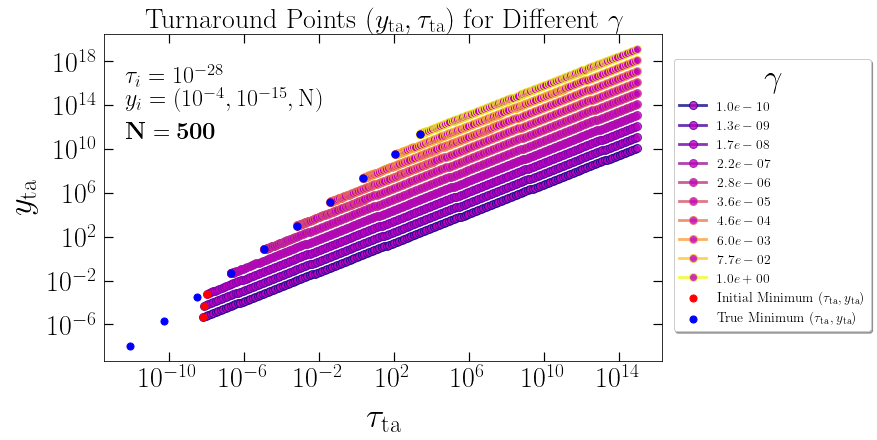

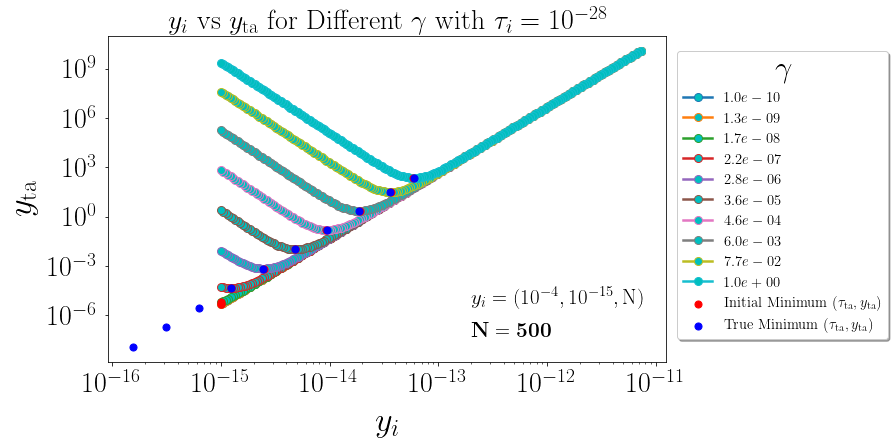

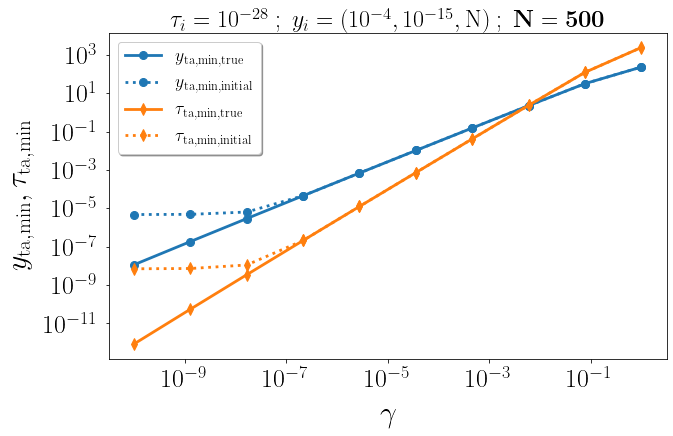


 **Initial minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 1.0000e-15, Tau_ta: 7.1148e-09, Y_ta: 4.7937e-06
Gamma: 1.3e-09, Y_i: 1.0000e-15, Tau_ta: 7.3655e-09, Y_ta: 4.9046e-06
Gamma: 1.7e-08, Y_i: 1.0000e-15, Tau_ta: 1.1230e-08, Y_ta: 6.4807e-06
Gamma: 2.2e-07, Y_i: 1.2251e-15, Tau_ta: 2.1273e-07, Y_ta: 4.5786e-05
Gamma: 2.8e-06, Y_i: 2.4934e-15, Tau_ta: 1.2636e-05, Y_ta: 6.9780e-04
Gamma: 3.6e-05, Y_i: 4.8235e-15, Tau_ta: 7.3472e-04, Y_ta: 1.0477e-02
Gamma: 4.6e-04, Y_i: 9.3313e-15, Tau_ta: 4.2124e-02, Y_ta: 1.5583e-01
Gamma: 6.0e-03, Y_i: 1.8991e-14, Tau_ta: 2.3635e+00, Y_ta: 2.2859e+00
Gamma: 7.7e-02, Y_i: 3.6739e-14, Tau_ta: 1.2422e+02, Y_ta: 3.2085e+01
Gamma: 1.0e+00, Y_i: 5.8013e-14, Tau_ta: 2.4636e+03, Y_ta: 2.3505e+02

**True minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 1.5619e-16, Tau_ta: 8.5439e-13, Y_ta: 1.1532e-08
Gamma: 1.3e-09, Y_i: 3.1381e-16, Tau_ta: 5.5634e-11, Y_ta: 1.8691e-07
Gamma: 1.7e-08, Y_i: 6.2394e-16, Tau_ta: 3.4898e-09, Y_ta: 2.9539e-06
Gamma: 2.2e-

In [20]:
# y_ta_min, tau_ta_min for various gamma-values with tau_i = 1e-28.


gamma_values = np.geomspace(1e-10, 1, 10)
N = 500
yi_values = np.geomspace(1e-4, 1e-15, N) 
tau_i, tau_f = 1e-28, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  



min_turnaround_pts = []
gamma_results = {}
for gamma in gamma_values:
    gamma_results[gamma] = {y_i: y_fdm(gamma, y_i) for y_i in yi_values}
    all_turnaround_pts = [turnaround for _, (_, turnaround) in gamma_results[gamma].items() if turnaround]
    if all_turnaround_pts:
        min_yi_ta, min_tau_ta, min_y_ta = min(all_turnaround_pts, key=lambda x: x[1])
        min_turnaround_pts.append((gamma, min_yi_ta, min_tau_ta, min_y_ta))

true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]

gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))




#plotting y vs tau for different values of gamma, each with different values of y_i
#for gamma in gamma_values:
   # fig1, ax1 = plt.subplots(figsize=(10, 6))
    #plt.rc('lines', linewidth = 2.8)
   # plt.rcParams['font.family'] = 'serif'
    #plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    #plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
    #for y_i in yi_values:
      #  sol, turnaround = gamma_results[gamma][y_i] 
       # tau_vals, y_vals = sol.t, sol.y[0]
       # ax1.loglog(tau_vals, y_vals, alpha=0.8, label=f"${y_i:.1e}$")
    #ax1.tick_params(axis='x', pad=6.9)
    #ax1.tick_params(axis='y', pad=6.9)
    #plt.xticks(fontsize=24)
    #plt.yticks(fontsize=24)
    #plt.xlabel(r'$\tau$', fontsize=30)
    #plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    #ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    #plt.savefig(f"yvstau3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    #plt.show()


    
    
    
    
fig2, ax2 = plt.subplots(figsize=(10, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
        sorted_points = sorted(set(zip(tau_ta, y_ta)))
        tau_ta, y_ta = zip(*sorted_points) 
        y_ta_scaled = [y * 10**i for y in y_ta]  
        ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], marker='o', 
                   label=f"${gamma:.1e}$", markersize=8, markerfacecolor='m', alpha=0.8)

gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)
min_yta_arr_scaled = [y * 10**i for i, y in enumerate(min_yta_arr)]
true_min_yta_arr_scaled = [y * 10**i for i, y in enumerate(true_min_yta_arr)]
ax2.scatter(min_tauta_arr, min_yta_arr_scaled, color='r', s = 50, zorder=10, label="Initial Minimum $( \\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax2.scatter(true_min_tauta_arr, true_min_yta_arr_scaled, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")



plt.text(5e-13, 1e16, r'$\tau_i = 10^{-28}$', fontsize=24)
plt.text(5e-13, 1e14, r'$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=24)
plt.text(5e-13, 1e11, r'$\mathbf{N = 500}$', fontsize=24)



ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=28)
ax2.legend(prop={'size':13.7}, loc=(1.02, 0.09), shadow=True, title=r'$\gamma$', title_fontsize=33,
           facecolor='white', fontsize=12)
#plt.savefig("yta_vs_tauta3_N500.pdf", bbox_inches='tight')
plt.show()




#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=8, markerfacecolor='c', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")


    
ax3.scatter(min_yi_arr, min_yta_arr, color='r', s = 50, zorder=10, label="Initial Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax3.scatter(true_min_yi_arr, true_min_yta_arr, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta}, y_\\mathrm{ta})$")

plt.text(2e-13, 5e-6, '$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=21)
plt.text(2e-13, 5e-8, r'$\mathbf{N = 500}$', fontsize=21)

ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax3.set_xlabel(r'$y_i$', fontsize=34.5, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax3.set_title(r'$y_i$ vs $y_\mathrm{ta}$ for Different $\gamma$ with $\tau_i = 10^{-28}$', fontsize=28)
ax3.legend(prop={'size':14.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=31,
           facecolor='white', fontsize=12)
#plt.savefig("yi_vs_yta3_N500.pdf", bbox_inches='tight')
plt.show()




# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
#true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]
gamma_arr, min_yi_arr7, min_tauta_arr7, min_yta_arr7 = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr7, true_min_tauta_arr7, true_min_yta_arr7 = zip(*true_min_turnaround_pts)

ax4.loglog(gamma_arr, true_min_yta_arr7, marker='o', markersize=8, color='C0', ls='-', label="True $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_yta_arr7, marker='o',  markersize=8,color='C0', ls=':', label="Initial $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, true_min_tauta_arr7, marker='d',  markersize=8, color='C1', ls='-', label="True $\tau_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_tauta_arr7, marker='d',  markersize=8, color='C1', ls=':', label="Initial $\tau_{\mathrm{ta, min}}$")

ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min, true}$", r"$y_\mathrm{ta, min, initial}$", r"$\tau_\mathrm{ta, min, true}$"
           , r"$\tau_\mathrm{ta, min, initial}$"], prop={'size':18}, loc='upper left', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)
plt.title(r' $\tau_i = 10^{-28}\;;\; y_i = (10^{-4}, 10^{-15}, \mathrm{N}) \;;\;  \mathbf{N = 500}$', fontsize=24)
#plt.savefig("ytamin_vs_gamma3_N500.pdf", bbox_inches='tight')
plt.show()


print("\n **Initial minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")

print("\n**True minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in true_min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")




**Final true minima:** gamma = 1.00e-10, y_i = 1.6753e-17, tau_ta = 1.2765e-12, y_ta = 1.5096e-08


**Final true minima:** gamma = 1.29e-09, y_i = 3.3317e-17, tau_ta = 7.9544e-11, y_ta = 2.3752e-07


**Final true minima:** gamma = 1.67e-08, y_i = 6.5909e-17, tau_ta = 4.8174e-09, y_ta = 3.6660e-06


**Final true minima:** gamma = 2.15e-07, y_i = 1.3107e-16, tau_ta = 2.8493e-07, y_ta = 5.5695e-05


**Final true minima:** gamma = 2.78e-06, y_i = 2.5673e-16, tau_ta = 1.6526e-05, y_ta = 8.3494e-04


**Final true minima:** gamma = 3.59e-05, y_i = 5.0540e-16, tau_ta = 9.4250e-04, y_ta = 1.2377e-02


**Final true minima:** gamma = 4.64e-04, y_i = 9.9000e-16, tau_ta = 5.2972e-02, y_ta = 1.8169e-01


**Final true minima:** gamma = 5.99e-03, y_i = 1.9345e-15, tau_ta = 2.9284e+00, y_ta = 2.6377e+00


**Final true minima:** gamma = 7.74e-02, y_i = 3.7424e-15, tau_ta = 1.5194e+02, y_ta = 3.6705e+01


**Final true minima:** gamma = 1.00e+00, y_i = 6.1549e-15, tau_ta = 2.9808e+03, y_ta = 2.6705e+02



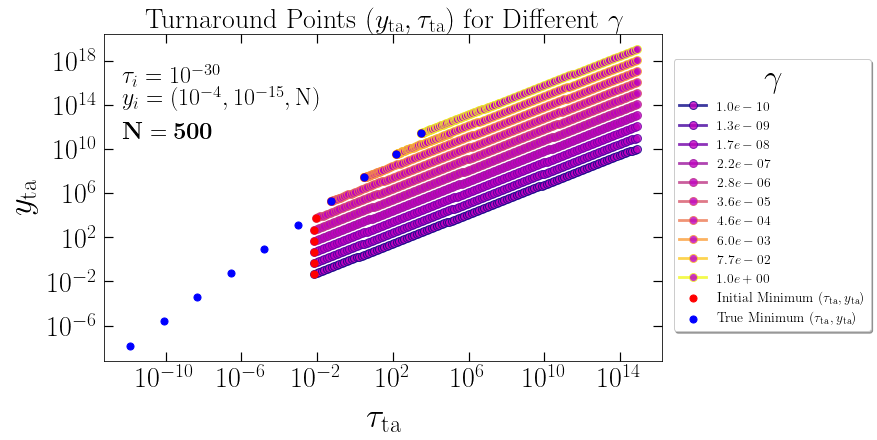

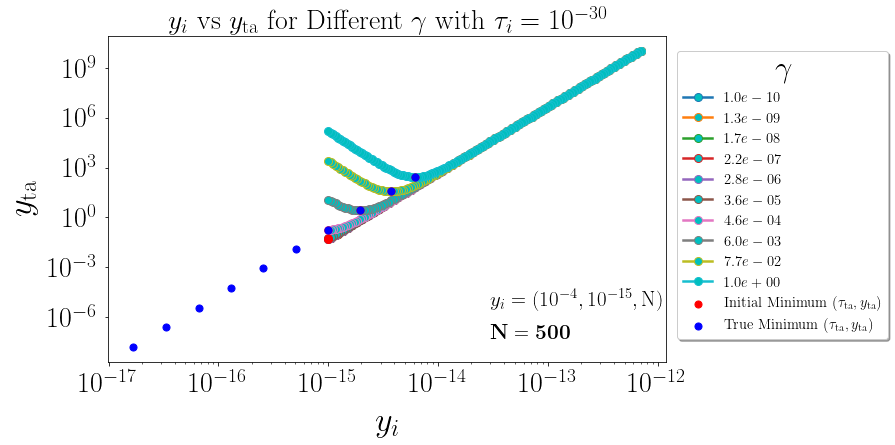

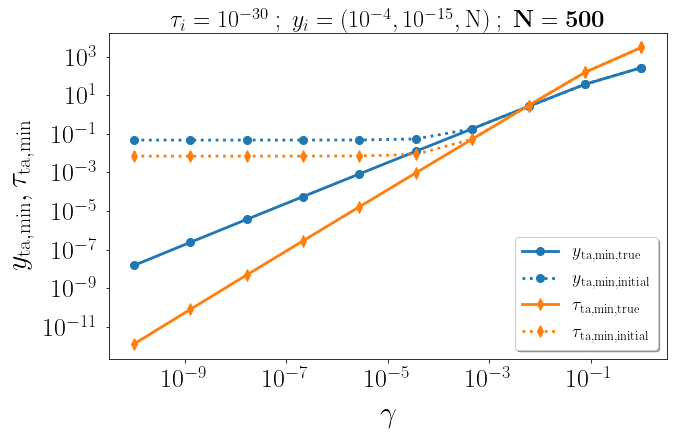


 **Initial minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 1.0000e-15, Tau_ta: 6.9645e-03, Y_ta: 4.7262e-02
Gamma: 1.3e-09, Y_i: 1.0000e-15, Tau_ta: 6.9645e-03, Y_ta: 4.7262e-02
Gamma: 1.7e-08, Y_i: 1.0000e-15, Tau_ta: 6.9652e-03, Y_ta: 4.7265e-02
Gamma: 2.2e-07, Y_i: 1.0000e-15, Tau_ta: 6.9733e-03, Y_ta: 4.7302e-02
Gamma: 2.8e-06, Y_i: 1.0000e-15, Tau_ta: 7.0793e-03, Y_ta: 4.7777e-02
Gamma: 3.6e-05, Y_i: 1.0000e-15, Tau_ta: 8.5560e-03, Y_ta: 5.4164e-02
Gamma: 4.6e-04, Y_i: 1.0000e-15, Tau_ta: 5.3001e-02, Y_ta: 1.8177e-01
Gamma: 6.0e-03, Y_i: 1.9345e-15, Tau_ta: 2.9284e+00, Y_ta: 2.6377e+00
Gamma: 7.7e-02, Y_i: 3.7424e-15, Tau_ta: 1.5194e+02, Y_ta: 3.6705e+01
Gamma: 1.0e+00, Y_i: 6.2171e-15, Tau_ta: 2.9831e+03, Y_ta: 2.6722e+02

**True minimum turnaround points:**
Gamma: 1.0e-10, Y_i: 1.6753e-17, Tau_ta: 1.2765e-12, Y_ta: 1.5096e-08
Gamma: 1.3e-09, Y_i: 3.3317e-17, Tau_ta: 7.9544e-11, Y_ta: 2.3752e-07
Gamma: 1.7e-08, Y_i: 6.5909e-17, Tau_ta: 4.8174e-09, Y_ta: 3.6660e-06
Gamma: 2.2e-

In [22]:
# y_ta_min, tau_ta_min for various gamma-values with tau_i = 1e-30.


gamma_values = np.geomspace(1e-10, 1, 10)
N = 500
yi_values = np.geomspace(1e-4, 1e-15, N) 
tau_i, tau_f = 1e-30, 1e15 
colors = ['C9','C8','C7','C6', 'C5', 'C4', 'C3', 'C2', 'C1', 'C0']  



min_turnaround_pts = []
gamma_results = {}
for gamma in gamma_values:
    gamma_results[gamma] = {y_i: y_fdm(gamma, y_i) for y_i in yi_values}
    all_turnaround_pts = [turnaround for _, (_, turnaround) in gamma_results[gamma].items() if turnaround]
    if all_turnaround_pts:
        min_yi_ta, min_tau_ta, min_y_ta = min(all_turnaround_pts, key=lambda x: x[1])
        min_turnaround_pts.append((gamma, min_yi_ta, min_tau_ta, min_y_ta))

true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]

gamma_colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
turnaround_colors = plt.cm.plasma(np.linspace(0, 1, len(gamma_values)))




#plotting y vs tau for different values of gamma, each with different values of y_i
#for gamma in gamma_values:
   # fig1, ax1 = plt.subplots(figsize=(10, 6))
    #plt.rc('lines', linewidth = 2.8)
   # plt.rcParams['font.family'] = 'serif'
    #plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
    #plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
    #for y_i in yi_values:
      #  sol, turnaround = gamma_results[gamma][y_i] 
       # tau_vals, y_vals = sol.t, sol.y[0]
       # ax1.loglog(tau_vals, y_vals, alpha=0.8, label=f"${y_i:.1e}$")
    #ax1.tick_params(axis='x', pad=6.9)
    #ax1.tick_params(axis='y', pad=6.9)
    #plt.xticks(fontsize=24)
    #plt.yticks(fontsize=24)
    #plt.xlabel(r'$\tau$', fontsize=30)
    #plt.ylabel(r'$y$', fontsize=30, labelpad=9)
    #ax1.set_title(rf'$\mathbf{{Evolution\ of\ }} y(\tau) \mathbf{{\ for\ }} \gamma={gamma:.1e}$', fontsize=20)
    #ax1.legend(prop={'size':13.7}, loc=(1.02, 0.1), shadow=True, title='$y_{i}$', title_fontsize=26,
              # facecolor='white', fontsize=12)
    #plt.savefig(f"yvstau3_gamma_{gamma:.1e}.pdf",  bbox_inches='tight')
    #plt.show()


    
    
    
    
fig2, ax2 = plt.subplots(figsize=(10, 6))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
        sorted_points = sorted(set(zip(tau_ta, y_ta)))
        tau_ta, y_ta = zip(*sorted_points) 
        y_ta_scaled = [y * 10**i for y in y_ta]  
        ax2.loglog(tau_ta, y_ta_scaled, color=turnaround_colors[i], marker='o', 
                   label=f"${gamma:.1e}$", markersize=8, markerfacecolor='m', alpha=0.8)

gamma_arr, min_yi_arr, min_tauta_arr, min_yta_arr = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr, true_min_tauta_arr, true_min_yta_arr = zip(*true_min_turnaround_pts)
min_yta_arr_scaled = [y * 10**i for i, y in enumerate(min_yta_arr)]
true_min_yta_arr_scaled = [y * 10**i for i, y in enumerate(true_min_yta_arr)]
ax2.scatter(min_tauta_arr, min_yta_arr_scaled, color='r', s = 50, zorder=10, label="Initial Minimum $( \\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax2.scatter(true_min_tauta_arr, true_min_yta_arr_scaled, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")



plt.text(5e-13, 1e16, r'$\tau_i = 10^{-30}$', fontsize=24)
plt.text(5e-13, 1e14, r'$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=24)
plt.text(5e-13, 1e11, r'$\mathbf{N = 500}$', fontsize=24)



ax2.tick_params(axis='x', pad=6.9)
ax2.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax2.set_xlabel(r'$\tau_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax2.set_title(r'Turnaround Points $(y_\mathrm{ta}, \tau_\mathrm{ta})$ for Different $\gamma$', fontsize=28)
ax2.legend(prop={'size':13.7}, loc=(1.02, 0.09), shadow=True, title=r'$\gamma$', title_fontsize=33,
           facecolor='white', fontsize=12)
#plt.savefig("yta_vs_tauta3_N500.pdf", bbox_inches='tight')
plt.show()




#plotting (y_ta, y_i) points for different values of gamma 
fig3, ax3 = plt.subplots(figsize=(10, 6))
for i, gamma in enumerate(gamma_values):
    turnaround_points = [turnaround for _, turnaround in gamma_results[gamma].values() if turnaround]
    if turnaround_points:
        yi_ta, tau_ta, y_ta = zip(*turnaround_points)
    ax3.loglog(yi_ta, y_ta, marker='o', markersize=8, markerfacecolor='c', linestyle='-', linewidth=2.5, label=f"${gamma:.1e}$")


    
ax3.scatter(min_yi_arr, min_yta_arr, color='r', s = 50, zorder=10, label="Initial Minimum $(\\tau_\\mathrm{ta},  y_\\mathrm{ta})$")
ax3.scatter(true_min_yi_arr, true_min_yta_arr, color='b', s = 50, zorder=10, label="True Minimum $(\\tau_\\mathrm{ta}, y_\\mathrm{ta})$")

plt.text(3e-14, 5e-6, '$y_i = (10^{-4}, 10^{-15}, \mathrm{N})$', fontsize=21)
plt.text(3e-14, 5e-8, r'$\mathbf{N = 500}$', fontsize=21)

ax3.tick_params(axis='x', pad=6.9)
ax3.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax3.set_xlabel(r'$y_i$', fontsize=34.5, labelpad=10)
ax3.set_ylabel(r'$y_\mathrm{ta}$', fontsize=34.5, labelpad=10)
ax3.set_title(r'$y_i$ vs $y_\mathrm{ta}$ for Different $\gamma$ with $\tau_i = 10^{-30}$', fontsize=28)
ax3.legend(prop={'size':14.7}, loc=(1.02, 0.07), shadow=True, title=r'$\gamma$', title_fontsize=31,
           facecolor='white', fontsize=12)
#plt.savefig("yi_vs_yta3_N500.pdf", bbox_inches='tight')
plt.show()




# y_ta_min, tau_ta_min vs gamma
fig4, ax4 = plt.subplots(figsize=(10, 6))
#true_min_turnaround_pts = [yta_true_min(gamma, y_i) for gamma, y_i, _, _ in min_turnaround_pts]
gamma_arr, min_yi_arr8, min_tauta_arr8, min_yta_arr8 = zip(*min_turnaround_pts)
gamma_arr, true_min_yi_arr8, true_min_tauta_arr8, true_min_yta_arr8 = zip(*true_min_turnaround_pts)

ax4.loglog(gamma_arr, true_min_yta_arr8, marker='o', markersize=8, color='C0', ls='-', label="True $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_yta_arr8, marker='o',  markersize=8,color='C0', ls=':', label="Initial $y_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, true_min_tauta_arr8, marker='d',  markersize=8, color='C1', ls='-', label="True $\tau_{\mathrm{ta, min}}$")
ax4.loglog(gamma_arr, min_tauta_arr8, marker='d',  markersize=8, color='C1', ls=':', label="Initial $\tau_{\mathrm{ta, min}}$")

ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax4.set_xlabel('$\gamma$', fontsize=30, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min},  \tau_\mathrm{ta, min}$', fontsize=30, labelpad=10)
ax4.legend([r"$y_\mathrm{ta, min, true}$", r"$y_\mathrm{ta, min, initial}$", r"$\tau_\mathrm{ta, min, true}$"
           , r"$\tau_\mathrm{ta, min, initial}$"], prop={'size':18}, loc='lower right', shadow=True,  title_fontsize=18,
           facecolor='white', fontsize=12)
plt.title(r' $\tau_i = 10^{-30}\;;\; y_i = (10^{-4}, 10^{-15}, \mathrm{N}) \;;\;  \mathbf{N = 500}$', fontsize=24)
#plt.savefig("ytamin_vs_gamma3_N500.pdf", bbox_inches='tight')
plt.show()


print("\n **Initial minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")

print("\n**True minimum turnaround points:**")
for gamma, y_i, tau_ta, y_ta in true_min_turnaround_pts:
    print(f"Gamma: {gamma:.1e}, Y_i: {y_i:.4e}, Tau_ta: {tau_ta:.4e}, Y_ta: {y_ta:.4e}")



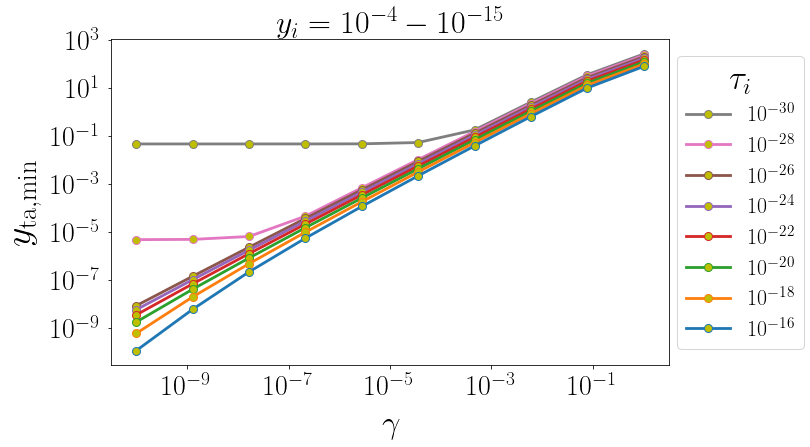

In [29]:
# y_ta_min vs gamma for various values of tau_i


fig4, ax4 = plt.subplots(figsize=(10, 6))

#70e000
ax4.loglog(gamma_arr, min_yta_arr8, 'C7', marker='o', markersize=8, markerfacecolor='y', ls = '-')
ax4.loglog(gamma_arr, min_yta_arr7, 'C6', marker='o', markersize=8, markerfacecolor='y', ls = '-')
ax4.loglog(gamma_arr, min_yta_arr6,'C5', marker='o', markersize=8, markerfacecolor='y',ls = '-')
ax4.loglog(gamma_arr, min_yta_arr5, 'C4', marker='o', markersize=8, markerfacecolor='y', ls = '-')
ax4.loglog(gamma_arr, min_yta_arr4, 'C3', marker='o', markersize=8, markerfacecolor='y', ls = '-')
ax4.loglog(gamma_arr, min_yta_arr3,'C2', marker='o', markersize=8, markerfacecolor='y',ls = '-')
ax4.loglog(gamma_arr, min_yta_arr2, 'C1', marker='o', markersize=8, markerfacecolor='y', ls = '-')
ax4.loglog(gamma_arr, min_yta_arr1, 'C0', marker='o', markersize=8, markerfacecolor='y',ls = '-')



ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax4.set_xlabel('$\gamma$', fontsize=33, labelpad=10)
ax4.set_ylabel(r'$y_\mathrm{ta, min}$', fontsize=38, labelpad=10)
ax4.legend([r"$ 10^{-30}$", "$ 10^{-28}$", "$10^{-26}$", r"$ 10^{-24}$", "$ 10^{-22}$", r"$ 10^{-20}$", "$ 10^{-18}$", r"$ 10^{-16}$"], 
            title_fontsize= 34,  prop={'size':22}, loc = (1.015, 0.05) ,facecolor='white', fontsize=12, title = r'$\tau_{i}$')

plt.title(r'$y_i = 10^{-4} - 10^{-15}$', fontsize= 32)

plt.savefig("yta_min_vs_gamma_difftaui.pdf", bbox_inches='tight')
plt.show()

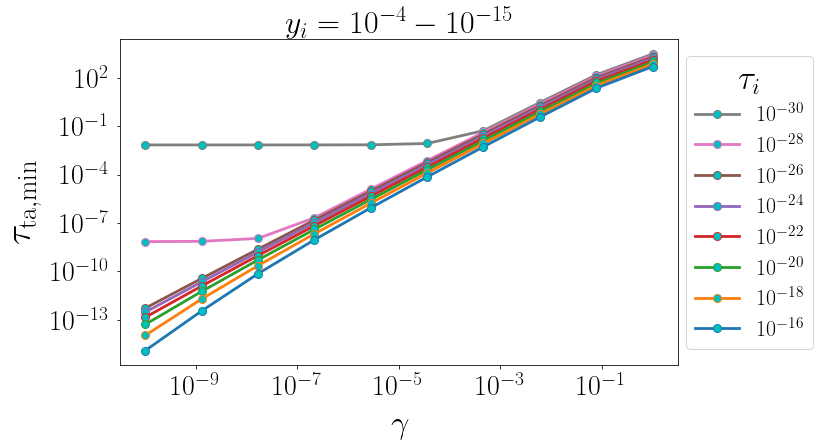

In [31]:
# tau_ta_min vs gamma for various values of tau_i


fig4, ax4 = plt.subplots(figsize=(10, 6))

ax4.loglog(gamma_arr, min_tauta_arr8, 'C7', marker='o', markersize=8, markerfacecolor='c', ls = '-')
ax4.loglog(gamma_arr, min_tauta_arr7, 'C6', marker='o', markersize=8, markerfacecolor='c', ls = '-')
ax4.loglog(gamma_arr, min_tauta_arr6,'C5', marker='o', markersize=8, markerfacecolor='c',ls = '-')
ax4.loglog(gamma_arr, min_tauta_arr5, 'C4', marker='o', markersize=8, markerfacecolor='c', ls = '-')
ax4.loglog(gamma_arr, min_tauta_arr4, 'C3', marker='o', markersize=8, markerfacecolor='c', ls = '-')
ax4.loglog(gamma_arr, min_tauta_arr3,'C2', marker='o', markersize=8, markerfacecolor='c',ls = '-')
ax4.loglog(gamma_arr, min_tauta_arr2, 'C1', marker='o', markersize=8, markerfacecolor='c', ls = '-')
ax4.loglog(gamma_arr, min_tauta_arr1, 'C0', marker='o', markersize=8, markerfacecolor='c',ls = '-')



ax4.tick_params(axis='x', pad=6.9)
ax4.tick_params(axis='y', pad=6.9)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
ax4.set_xlabel('$\gamma$', fontsize=33, labelpad=10)
ax4.set_ylabel(r'$\tau_\mathrm{ta, min}$', fontsize=38, labelpad=10)
ax4.legend([r"$ 10^{-30}$", "$ 10^{-28}$", "$10^{-26}$", r"$ 10^{-24}$", "$ 10^{-22}$", r"$ 10^{-20}$", "$ 10^{-18}$", r"$ 10^{-16}$"], 
            title_fontsize= 34,  prop={'size':22}, loc = (1.015, 0.05) ,facecolor='white', fontsize=12, title = r'$\tau_{i}$')

plt.title(r'$y_i = 10^{-4} - 10^{-15}$', fontsize= 32)
plt.savefig("tauta_min_vs_gamma_difftaui.pdf", bbox_inches='tight')
plt.show()

